In [ ]:
!pip3 install torch torchvision torchaudio --quiet
!pip install gpytorch --quiet
!pip install mne --quiet
!pip install pandas --quiet
!pip install pywavelets --quiet
!pip install edfio --quiet
!pip install tqdm --quiet
!pip install POT --quiet
!pip install scikit-survival --quiet
!pip install pycox --quiet
!pip install lifelines --quiet

### Dataset Info
#### SHHS1 (Baseline and First Follow-up Visits):

- Data Collection Period: Between November 1, 1995, and January 31, 1998.
- Participants: 6441 individuals.
- Purpose: Establish baseline measurements for sleep-disordered breathing and associated cardiovascular and other health outcomes.
- Inclusion Criteria: Age 40 years or older, no history of treatment for sleep apnea, no tracheostomy, no current home oxygen therapy.
- Data Collected: Initial polysomnogram (PSG), various cardiovascular risk factors, and other health data.


#### Events Data:

- Baseline: The initial PSG and associated health data collected during SHHS1 (1995-1998).
- Follow-up: Subsequent health events recorded after SHHS1, including cardiovascular events, revascularization procedures, heart attacks, strokes, and mortality. The follow-up events data extends from the baseline period to the time of the last contact or death.

In [ ]:
import os
import tqdm
import ot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import xml.etree.ElementTree as ET
from itertools import product
from multiprocessing import Pool
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import seaborn as sns
from lifelines import CoxPHFitter

import mne
from mne.stats.parametric import _parametric_ci
from mne import create_info
from mne.io import RawArray

from KC_algorithm.model import score_KCs
from KC_algorithm.utils import EpochData
from KC_algorithm.plotting import KC_from_probas, plot_all_Kcs

from utils.plots import plot_Kcs_in_single_chart, plot_Kcs_in_single_chart_epoch_data, plot_kcs_per_minute_and_sleep_stages, KC_from_probas_epoch_data
from utils.io import import_event_and_stages_SHHS, get_total_recording_time, store_kcs_data, load_kcs_edf_files, load_invalid_kc_metadata, load_valid_kc_metadata
from utils.preprocessing import remove_steady_epochs, remove_standard_deviation_outliers
from utils.postprocessing import calculate_kcs_per_minute, filter_kcs_by_sleep_stages

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
from sksurv.preprocessing import OneHotEncoder

In [ ]:
matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' : 11,
})

In [ ]:
DATASET_DIR = "/home/ec2-user/SageMaker/datasets/nsrr/shhs/"

datasets_dir = os.path.join(DATASET_DIR, 'datasets-preprocessed')
datasets_dir_preprocessed = os.path.join(DATASET_DIR, 'datasets-preprocessed')

# Individual datasets with population & events data
population_dataset_enriched = os.path.join(datasets_dir, 'shhs1-dataset-0.20.0.csv')
events_dataset = os.path.join(datasets_dir, 'shhs-cvd-summary-dataset-0.20.0.csv')

variables_dataset = os.path.join(datasets_dir_preprocessed, 'shhs-data-dictionary-0.20.0-variables.csv')
density_dataset = os.path.join(datasets_dir_preprocessed, 'enriched-avg-kc-density-backup.csv')
features_dataset = os.path.join(datasets_dir_preprocessed, 'enriched-kc_features-backup.csv')

# Load the datasets to make them globally available
variables_df = pd.read_csv(variables_dataset)
events_df = pd.read_csv(events_dataset)
density_df = pd.read_csv(density_dataset)
features_df = pd.read_csv(features_dataset)


# Gender and age category labels
GENDER_LABELS = {1: 'Male', 2: 'Female'}
AGE_LABELS = {
    5: '35-44 years', 6: '45-54 years', 7: '55-64 years',
    8: '65-74 years', 9: '75-84 years', 10: '85 years or older'
}

In [ ]:
pd.set_option('display.max_columns', None)

### Merge density and features to population df

In [6]:
# Drop 'Unnamed: 0' and 'index' columns if they exist
features_df = features_df.drop(columns=['Unnamed: 0', 'index'], errors='ignore')
density_df = density_df.drop(columns=['Unnamed: 0', 'index'], errors='ignore')
# Find overlapping columns (excluding 'nsrrid')
overlapping_columns = set(features_df.columns).intersection(set(density_df.columns)) - {'nsrrid'}
print("Overlapping columns:", overlapping_columns)
# Remove overlapping columns from one of the DataFrames (here we choose density_df)
density_df = density_df.drop(columns=overlapping_columns, errors='ignore')
# Merge the DataFrames on 'nsrrid'
population_df = pd.merge(features_df, density_df, on='nsrrid', how='inner')

Overlapping columns: {'height', 'gender', 'age_category_s1', 'waist', 'bmi_s1', 'ethnicity', 'avgsat', 'weight', 'minsat'}


### Merge population with previous events

Two things here:
- Add *previous* events (like prev_stk) to the population_df
- Specify the columns for preprocessing (numeric vs. one-hot)

In [7]:
# population columns for preprocessing
id_columns = ['nsrrid']
one_hot_columns = ['gender', 'ethnicity', 'age_category_s1']
numeric_columns = population_df.columns.difference(one_hot_columns + id_columns)

# Events columns for preprocessing
event_prev_events_columns = ['prev_mi', 'prev_mip', 'prev_stk', 'prev_chf', 'prev_revpro', 'prev_ang']
event_numeric_columns = ["age_s1"]
event_additional_columns = ["censdate"] # Used for filling in missing time
event_id_columns = ["nsrrid"]

# Values to use for the features df
events_features_df = events_df[event_id_columns + event_numeric_columns + event_additional_columns + event_prev_events_columns]

time_event_dict = {
    'mi_date': 'mi',  # Days to First myocardial infarction (MI) Since Baseline
    'mip_date': 'mip',  # Days to First myocardial infarction (MI) Procedure Since Baseline
    'stk_date': 'stroke',  # Days to First Stroke Since Baseline
    'chd_dthdt': 'chd_death',  # Days to Fatal Coronary Heart Disease (CHD) Since Baseline
    'cvd_dthdt': 'cvd_death',  # Days to Fatal Cardiovascular Disease (CVD) Since Baseline
    'ang_date': 'angina',  # Days to First Angina Episodes Since Baseline
    'revpro_date': 'revasc_proc',  # Days to First Revascularization Procedure Since Baseline
    'ptca_date': 'ptca',  # Days to First Percutaneous transluminal coronary angioplasty (PTCA) Since Baseline
    'cabg_date': 'cabg',  # Days to First coronary artery bypass graft surgery (CABG) Since Baseline
    'chf_date': 'chf',  # Days to First Congestive Heart Failure (CHF) Since Baseline
    'censdate': 'vital'  # Days to Most Recent Contact or Death Since Baseline
}

# Seperate the different columns
feature_id_columns = ['nsrrid']
feature_one_hot_columns = ['gender', 'ethnicity', 'age_category_s1']
feature_numeric_columns = list(population_df.columns.difference(one_hot_columns + id_columns))

# Merge the final dataset
population_df_not_norm = pd.merge(population_df, events_features_df, on='nsrrid', how='left')

# Columns names by preprocessing type
final_id_columns = feature_id_columns
final_one_hot_columns = feature_one_hot_columns
final_numeric_columns = feature_numeric_columns + event_numeric_columns + event_prev_events_columns

In [8]:
population_df_not_norm.head()

,nsrrid,bmi_s1,gender,height,weight,waist,age_category_s1,avgsat,minsat,ethnicity,avg_std_kc-thr_0.5-sleepstages_2-smoothing_5,global_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_index-thr_0.5-sleepstages_2-smoothing_5,global_min_std-thr_0.5-sleepstages_2-smoothing_5,global_min_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_max_value-thr_0.5-sleepstages_2-smoothing_5,min_max_duration-thr_0.5-sleepstages_2-smoothing_5,max_max_duration-thr_0.5-sleepstages_2-smoothing_5,variance_duration-thr_0.5-sleepstages_2-smoothing_5,right_peak_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_index-thr_0.5-sleepstages_2-smoothing_5,right_peak_std-thr_0.5-sleepstages_2-smoothing_5,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_index-thr_0.5-sleepstages_2-smoothing_5,left_peak_std-thr_0.5-sleepstages_2-smoothing_5,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_5,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_5,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_5,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_5,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_5,avg_std_kc-thr_0.5-sleepstages_2-smoothing_10,global_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_index-thr_0.5-sleepstages_2-smoothing_10,global_min_std-thr_0.5-sleepstages_2-smoothing_10,global_min_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_max_value-thr_0.5-sleepstages_2-smoothing_10,min_max_duration-thr_0.5-sleepstages_2-smoothing_10,max_max_duration-thr_0.5-sleepstages_2-smoothing_10,variance_duration-thr_0.5-sleepstages_2-smoothing_10,right_peak_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_index-thr_0.5-sleepstages_2-smoothing_10,right_peak_std-thr_0.5-sleepstages_2-smoothing_10,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_index-thr_0.5-sleepstages_2-smoothing_10,left_peak_std-thr_0.5-sleepstages_2-smoothing_10,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_10,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_10,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_10,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_10,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_10,avg_std_kc-thr_0.5-sleepstages_2-smoothing_20,global_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_index-thr_0.5-sleepstages_2-smoothing_20,global_min_std-thr_0.5-sleepstages_2-smoothing_20,global_min_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_max_value-thr_0.5-sleepstages_2-smoothing_20,min_max_duration-thr_0.5-sleepstages_2-smoothing_20,max_max_duration-thr_0.5-sleepstages_2-smoothing_20,variance_duration-thr_0.5-sleepstages_2-smoothing_20,right_peak_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_index-thr_0.5-sleepstages_2-smoothing_20,right_peak_std-thr_0.5-sleepstages_2-smoothing_20,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_index-thr_0.5-sleepstages_2-smoothing_20,left_peak_std-thr_0.5-sleepstages_2-smoothing_20,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_20,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_20,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_20,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_20,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_20,avg_std_kc-thr_0.5-sleepstages_3-smoothing_5,global_min_value-thr_0.5-sleepstages_3-smoothing_5,global_min_index-thr_0.5-sleepstages_3-smoothing_5,global_min_std-thr_0.5-slee

### Merge datasets together
- Select target columns (stroke or alive)
- Fuse to final population_df


For stroke, we only have 287 actual events. The rest is censored...

In [9]:
def get_dataset(event_time_column, event_column, sleep_stages, threshold):
    event_df = events_df[["nsrrid", event_time_column, event_column]]

    # Merge event with population dataframe
    population_df = pd.merge(population_df_not_norm, event_df, on='nsrrid')
    population_df = population_df.drop(["nsrrid"], axis=1)

    # Drop all nan rows of columns event_column
    population_df = population_df.dropna(subset=[event_column])

    # Add the censdate to all rows where event_time_column is nan
    population_df[event_time_column].fillna(population_df["censdate"], inplace=True)

    # Drop all values where event_time_column is still nan
    population_df = population_df.dropna(subset=[event_time_column])

    # Turn event column into binary True/False
    population_df[event_column] = population_df[event_column].apply(lambda x: x > 0)

    # Some columns contain a lot of Nan. We drop them
    cols_to_drop = ['prev_revpro', 'prev_ang', 'waist', 'weight', 'height']

    columns_to_keep = list(population_df.columns.difference(cols_to_drop))

    # Given that we have a wide set of features, we now want to filter out only a subset as otherwise the data is collinear
    sleep_stages_columns = [f'{sleep_stage}' for sleep_stage in sleep_stages]
    sleep_stages_columns_identifier = f'sleepstages_{"_".join(sleep_stages_columns)}'
    threshold_columns_identifier = f'thr_{threshold}'

    columns_to_keep = [col for col in columns_to_keep if "smoothing_10" not in col and "smoothing_20" not in col]

    if len(sleep_stages) == 1 and sleep_stages[0] == 2:
        columns_to_keep = [col for col in columns_to_keep if ("sleepstages_" in col and sleep_stages_columns_identifier in col and threshold_columns_identifier in col) or "sleepstages_" not in col]
        columns_to_keep = [col for col in columns_to_keep if ("sleepstages_" in col and "sleepstages_2_3" not in col) or "sleepstages_" not in col]
    else:
        columns_to_keep = [col for col in columns_to_keep if ("sleepstages_" in col and sleep_stages_columns_identifier in col and threshold_columns_identifier in col) or "sleepstages_" not in col]


    data_x = population_df[columns_to_keep]
    
    data_x_numeric = OneHotEncoder().fit_transform(data_x)
    print("Before dropping nan: ", data_x_numeric.shape)
    data_x_numeric = data_x_numeric.dropna()
    print("After dropping nan: ", data_x_numeric.shape)

    # Create the structured array for sksurv
    data_y = np.array(
        [(event, time) for event, time in zip(data_x_numeric[event_column], data_x_numeric[event_time_column])],
        dtype=[("Status", 'bool'), ("Survival_in_days", 'f8')]
    )
    data_x = data_x_numeric.drop([event_column, event_time_column, "censdate"], axis=1)

    return data_x, data_y

event_time_column = "stk_date"
event_column = time_event_dict[event_time_column]
sleep_stages = [2,3]
threshold = 0.5

data_x, data_y = get_dataset(event_time_column, event_column, sleep_stages, threshold)
print("Data of shape data_x: ", data_x.shape, " data_y: ", data_y.shape)

Before dropping nan:  (5037, 43)
After dropping nan:  (5009, 43)
Data of shape data_x:  (5009, 40)  data_y:  (5009,)


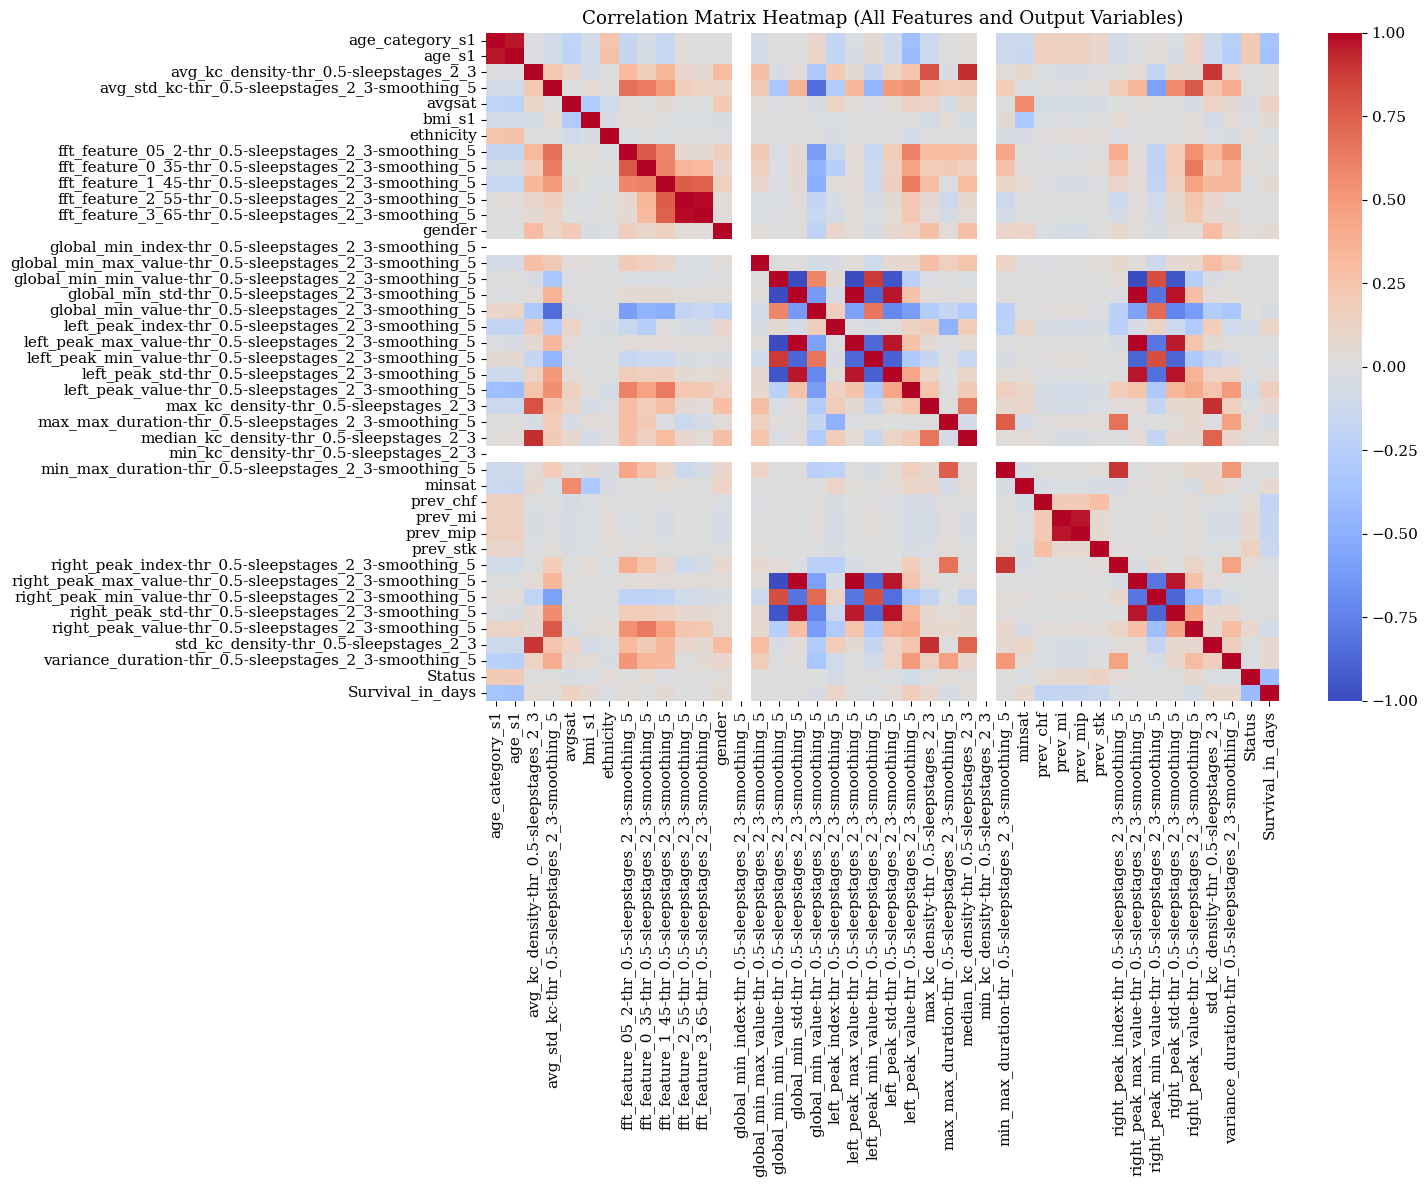

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert data_y to a DataFrame
data_y_df = pd.DataFrame(data_y)

# Concatenate data_x and data_y
combined_data = pd.concat([data_x.reset_index(drop=True), data_y_df.reset_index(drop=True)], axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix Heatmap (All Features and Output Variables)')
plt.tight_layout()
#plt.savefig('correlation_matrix_heatmap_thr-0.8.png', dpi=300, bbox_inches='tight')

plt.show()

In [11]:
correlation_matrix["prev_mi"].abs().sort_values(ascending=False)

prev_mi                                                     1.000000
prev_mip                                                    0.968576
prev_chf                                                    0.200443
Survival_in_days                                            0.157760
age_s1                                                      0.148428
age_category_s1                                             0.143710
Status                                                      0.072361
prev_stk                                                    0.067133
left_peak_value-thr_0.5-sleepstages_2_3-smoothing_5         0.065542
left_peak_index-thr_0.5-sleepstages_2_3-smoothing_5         0.059799
max_kc_density-thr_0.5-sleepstages_2_3                      0.054790
gender                                                      0.053063
avgsat                                                      0.047237
std_kc_density-thr_0.5-sleepstages_2_3                      0.044342
avg_kc_density-thr_0.5-sleepstages

### Understand distribution of right/left peak
- I need to remove outliers: Everything above 250 mV!

Processing threshold: 0.5
Before dropping nan:  (5037, 43)
After dropping nan:  (5009, 43)
Processing threshold: 0.7
Before dropping nan:  (5037, 43)
After dropping nan:  (4872, 43)
Processing threshold: 0.8
Before dropping nan:  (5037, 43)
After dropping nan:  (4845, 43)
Processing threshold: 0.9
Before dropping nan:  (5037, 43)
After dropping nan:  (4800, 43)


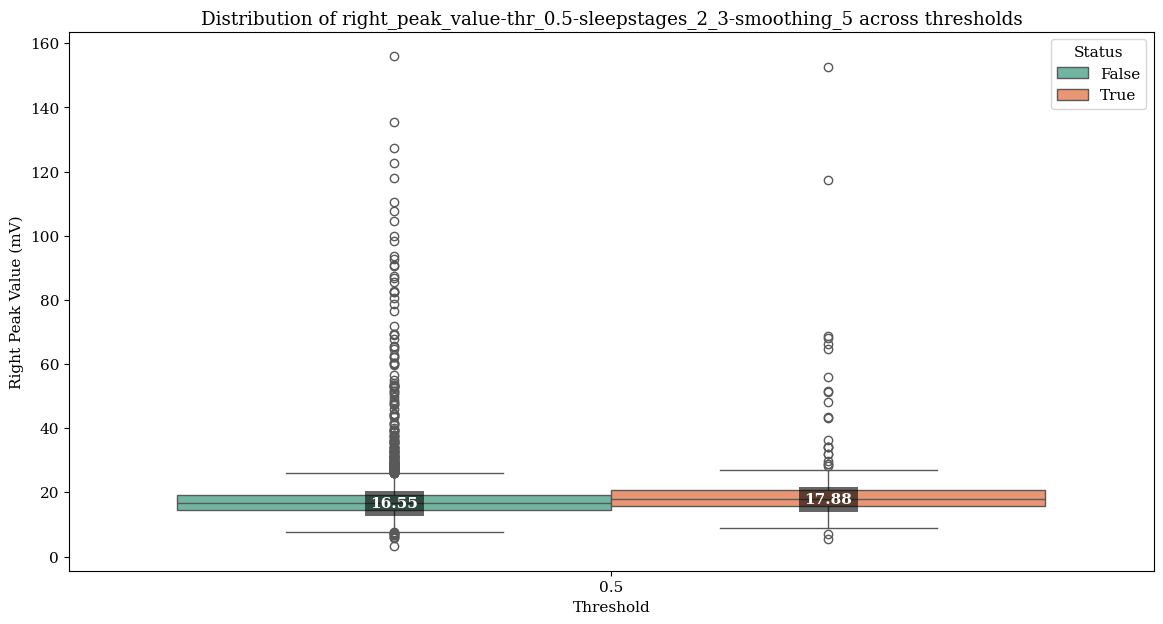

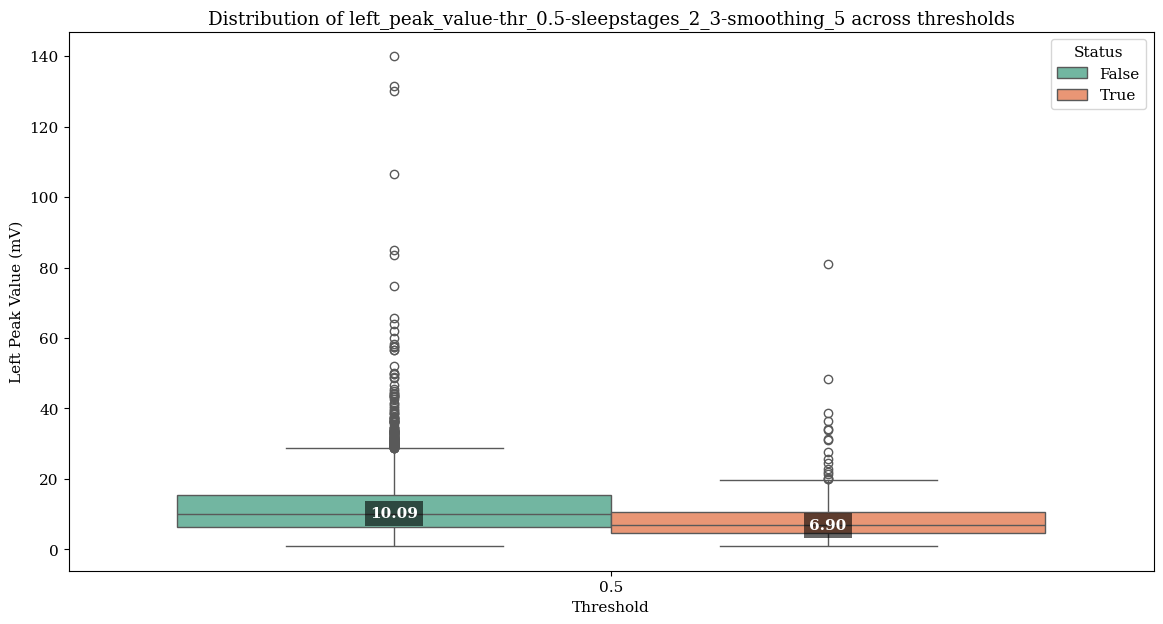

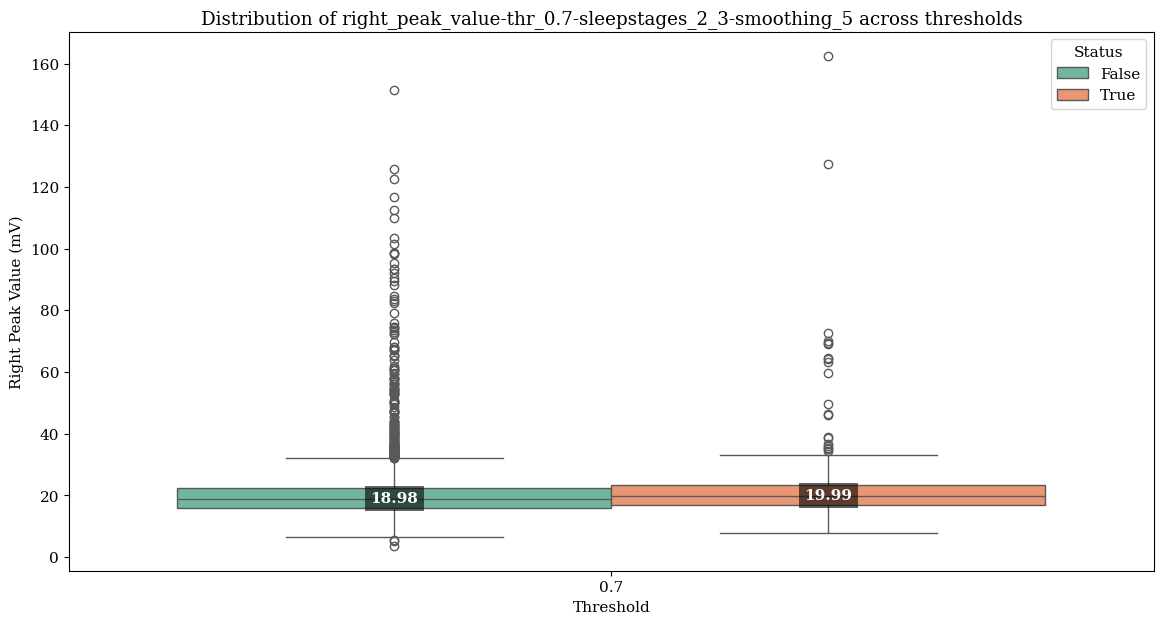

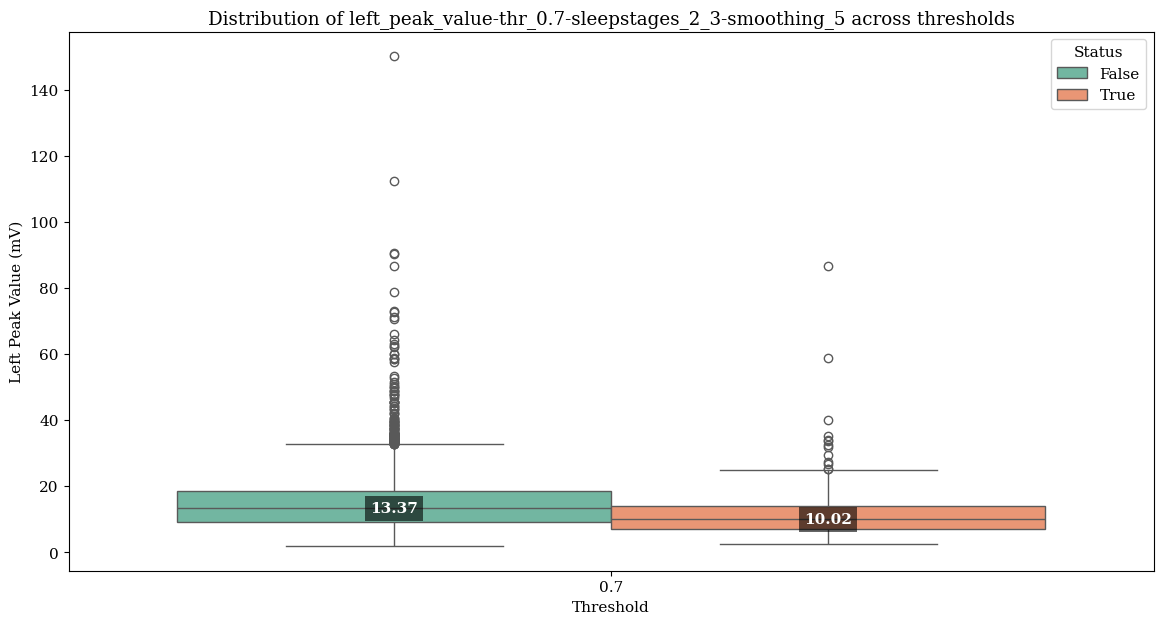

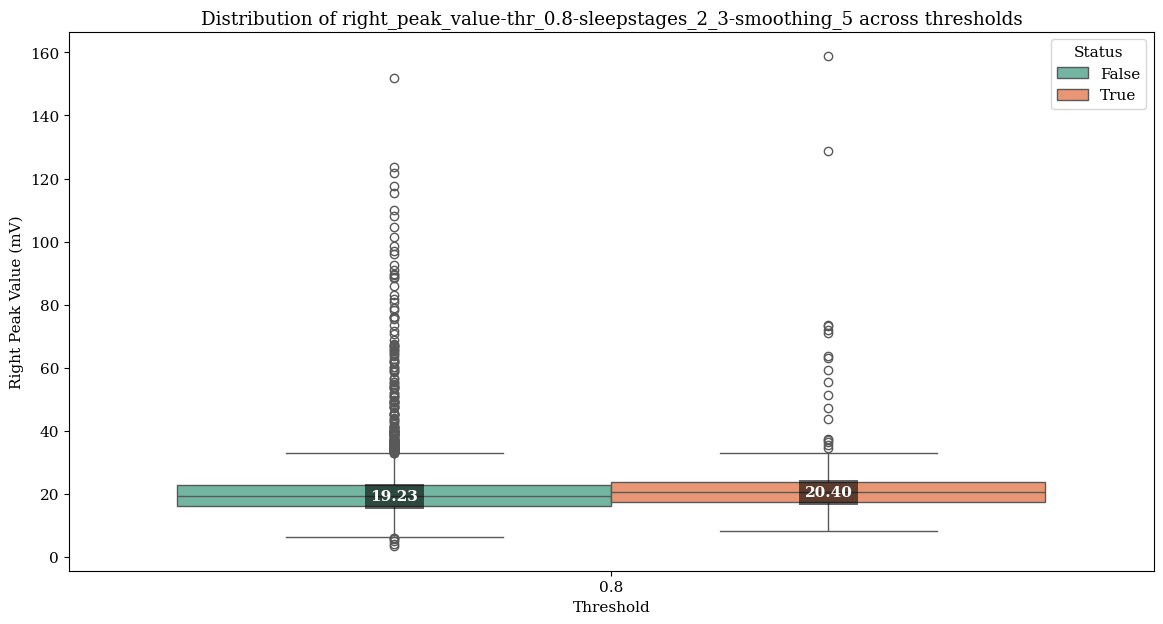

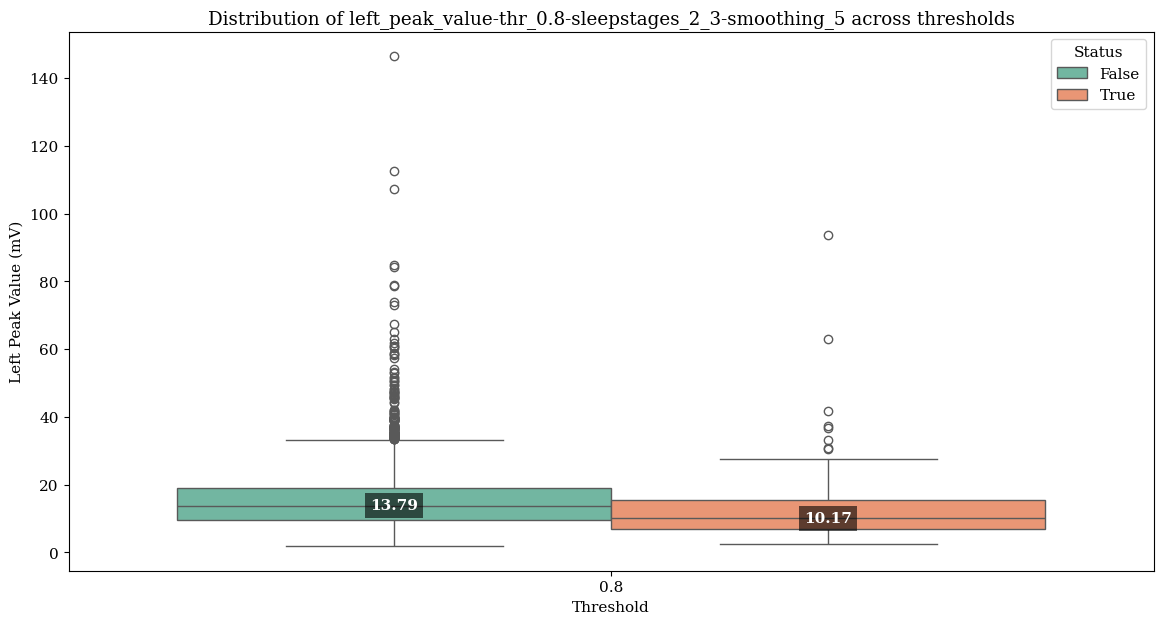

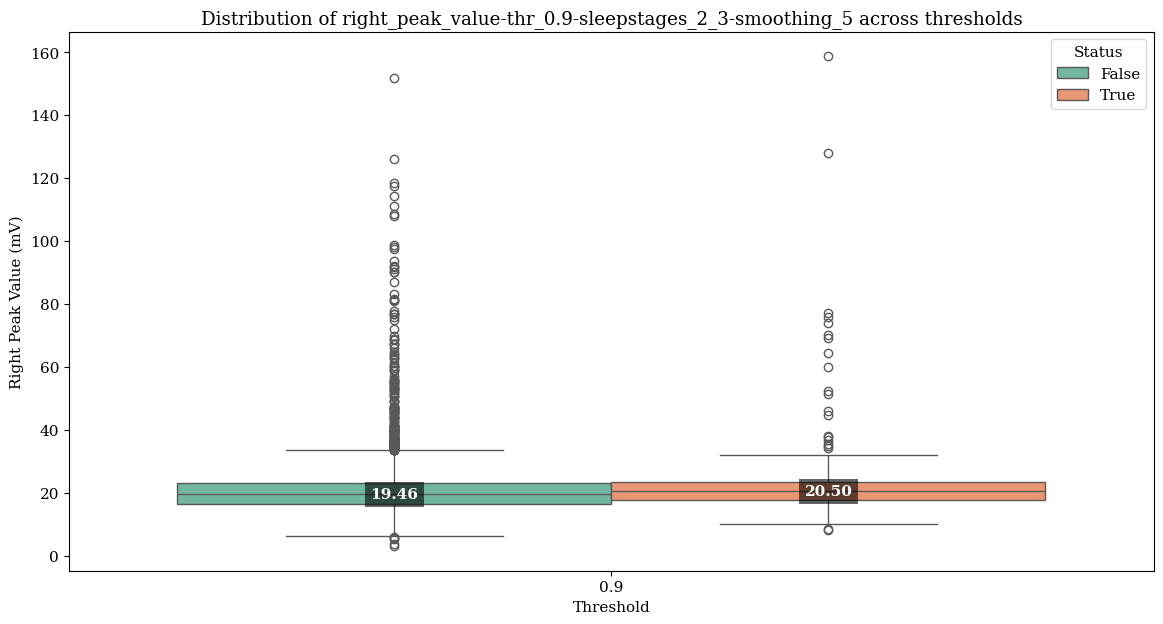

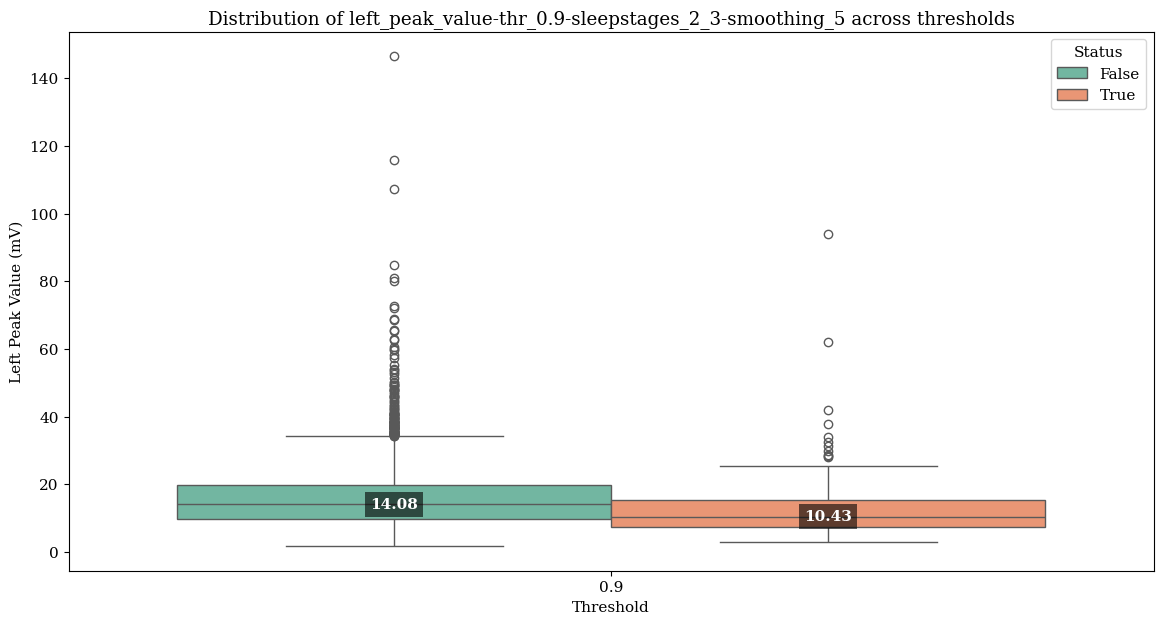

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

THRESHOLD = 250

def plot_distributions(event_time_column, event_column, sleep_stages, thresholds):
    # Initialize empty lists to collect data for each threshold
    aggregated_data = []
    feature_names = []  # To store the correct feature names for each threshold
    
    base_feature_right = "right_peak_value-thr*-sleepstages_2_3-smoothing_5"
    base_feature_left = "left_peak_value-thr*-sleepstages_2_3-smoothing_5"
    
    for threshold in thresholds:
        print(f"Processing threshold: {threshold}")
        # Get the dataset for the current threshold
        data_x, data_y = get_dataset(event_time_column, event_column, sleep_stages, threshold)
        
        # Construct actual column names based on the threshold
        right_feature = base_feature_right.replace("thr*", f"thr_{threshold}")
        left_feature = base_feature_left.replace("thr*", f"thr_{threshold}")
        feature_names.append((right_feature, left_feature))  # Store the names for later use
        
        # Check if these columns exist in data_x
        if right_feature in data_x.columns and left_feature in data_x.columns:
            plot_data = data_x[[right_feature, left_feature]].copy()
            plot_data['Status'] = data_y['Status']
            plot_data['Threshold'] = threshold  # Add threshold for later grouping
            
            # Remove rows where either feature exceeds 250 mV
            plot_data = plot_data[(plot_data[right_feature] <= THRESHOLD) & (plot_data[left_feature] <= THRESHOLD)]
            
            # Append to aggregated list
            aggregated_data.append(plot_data)
        else:
            print(f"Columns {right_feature} or {left_feature} not found in data_x at threshold {threshold}")
    
    # Combine all the collected data into a single DataFrame
    if aggregated_data:
        aggregated_df = pd.concat(aggregated_data)
        
        for right_feature, left_feature in feature_names:
            threshold = right_feature.split("thr_")[1].split("-")[0]  # Extract threshold value
            
            # Plot the distribution for the right feature
            plt.figure(figsize=(14, 7))
            ax = sns.boxplot(data=aggregated_df[aggregated_df['Threshold'] == float(threshold)], 
                             x='Threshold', y=right_feature, hue='Status', palette='Set2')
            
            # Add median values
            add_median_values(ax, aggregated_df[aggregated_df['Threshold'] == float(threshold)], 
                              'Threshold', right_feature, 'Status')
            
            plt.title(f'Distribution of {right_feature} across thresholds')
            plt.ylabel("Right Peak Value (mV)")
            plt.savefig(f'{right_feature}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Plot the distribution for the left feature
            plt.figure(figsize=(14, 7))
            ax = sns.boxplot(data=aggregated_df[aggregated_df['Threshold'] == float(threshold)], 
                             x='Threshold', y=left_feature, hue='Status', palette='Set2')
            
            # Add median values
            add_median_values(ax, aggregated_df[aggregated_df['Threshold'] == float(threshold)], 
                              'Threshold', left_feature, 'Status')
            
            plt.title(f'Distribution of {left_feature} across thresholds')
            plt.ylabel("Left Peak Value (mV)")
            plt.savefig(f'{left_feature}.png', dpi=300, bbox_inches='tight')
            plt.show()
    else:
        print("No valid data available for plotting.")

def add_median_values(ax, data, x, y, hue):
    for i, threshold in enumerate(data[x].unique()):
        for j, status in enumerate(data[hue].unique()):
            median = data[(data[x] == threshold) & (data[hue] == status)][y].median()
            if np.isfinite(median):  # Check if median is a finite number
                ax.text(i + j*0.4 - 0.2, median, f'{median:.2f}', 
                        horizontalalignment='center', verticalalignment='center',
                        fontweight='bold', color='white',
                        bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'))
            else:
                print(f"Non-finite median found for threshold {threshold}, status {status}")

# Example usage remains the same
event_time_column = "stk_date"
event_column = time_event_dict[event_time_column]
sleep_stages = [2, 3]
thresholds = [0.5, 0.7, 0.8, 0.9]
plot_distributions(event_time_column, event_column, sleep_stages, thresholds)

### Understand distribution by gender

Processing threshold: 0.5
Before dropping nan:  (5037, 43)
After dropping nan:  (5009, 43)
Processing threshold: 0.7
Before dropping nan:  (5037, 43)
After dropping nan:  (4872, 43)
Processing threshold: 0.8
Before dropping nan:  (5037, 43)
After dropping nan:  (4845, 43)
Processing threshold: 0.9
Before dropping nan:  (5037, 43)
After dropping nan:  (4800, 43)


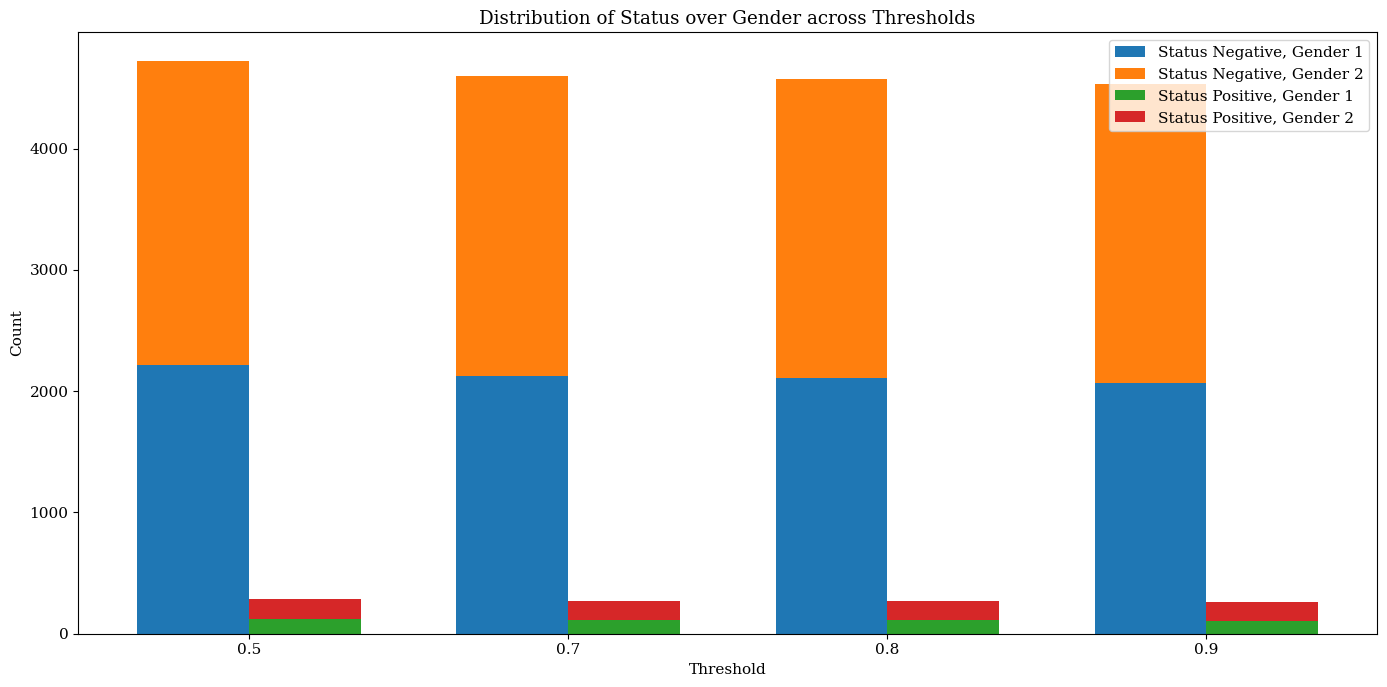

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_status_gender_distribution(event_time_column, event_column, gender_column, sleep_stages, thresholds, get_dataset):
    # Initialize a list to collect the data
    aggregated_data = []
    
    for threshold in thresholds:
        print(f"Processing threshold: {threshold}")
        # Get the dataset for the current threshold
        data_x, data_y = get_dataset(event_time_column, event_column, sleep_stages, threshold)
        
        # Check if the required columns exist
        if gender_column in data_x.columns and 'Status' in data_y.dtype.names:
            plot_data = data_x[[gender_column]].copy()
            plot_data['Status'] = data_y['Status']
            plot_data['Threshold'] = threshold  # Add threshold for grouping
            
            # Append to aggregated list
            aggregated_data.append(plot_data)
        else:
            print(f"Required columns not found in data at threshold {threshold}")
    
    # Combine all the collected data into a single DataFrame
    if aggregated_data:
        aggregated_df = pd.concat(aggregated_data)
        
        # Create a grouped DataFrame instead of a pivot table
        grouped_data = aggregated_df.groupby(['Threshold', 'Status', 'gender']).size().unstack(fill_value=0)
        grouped_data = grouped_data.reset_index()
        
        # Plot the stacked bar chart
        fig, ax = plt.subplots(figsize=(14, 7))
        
        bar_width = 0.35
        index = np.arange(len(thresholds))
        
        for i, status in enumerate([False, True]):
            status_data = grouped_data[grouped_data['Status'] == status]
            bottom = np.zeros(len(thresholds))
            for gender in [1, 2]:
                if gender in status_data.columns:
                    ax.bar(index + i*bar_width, status_data[gender], bar_width,
                           bottom=bottom, label=f'Status {"Positive" if status else "Negative"}, Gender {gender}')
                    bottom += status_data[gender]
        
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Count')
        ax.set_title('Distribution of Status over Gender across Thresholds')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(thresholds)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig('gender-distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No valid data available for plotting.")

# Example usage remains the same
event_time_column = "stk_date"
event_column = time_event_dict[event_time_column]  # Assuming this variable is defined elsewhere
gender_column = "gender"
sleep_stages = [2, 3]
thresholds = [0.5, 0.7, 0.8, 0.9]

# You need to provide the get_dataset function
plot_status_gender_distribution(event_time_column, event_column, gender_column, sleep_stages, thresholds, get_dataset)

#### Survival Analysis

Text(0.5, 0, 'time $t$')

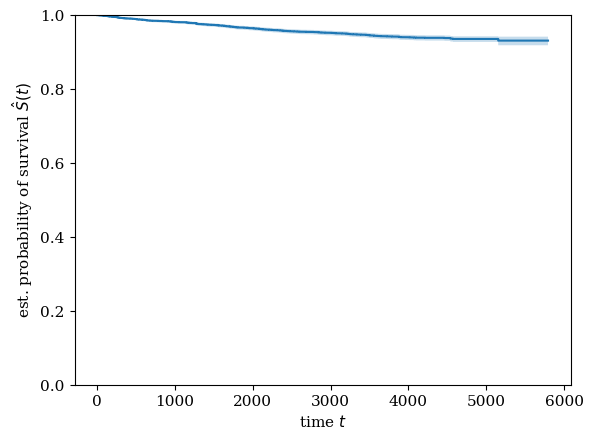

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [15]:
data_x.head()

,age_category_s1,age_s1,avg_kc_density-thr_0.5-sleepstages_2_3,avg_std_kc-thr_0.5-sleepstages_2_3-smoothing_5,avgsat,bmi_s1,ethnicity,fft_feature_05_2-thr_0.5-sleepstages_2_3-smoothing_5,fft_feature_0_35-thr_0.5-sleepstages_2_3-smoothing_5,fft_feature_1_45-thr_0.5-sleepstages_2_3-smoothing_5,fft_feature_2_55-thr_0.5-sleepstages_2_3-smoothing_5,fft_feature_3_65-thr_0.5-sleepstages_2_3-smoothing_5,gender,global_min_index-thr_0.5-sleepstages_2_3-smoothing_5,global_min_max_value-thr_0.5-sleepstages_2_3-smoothing_5,global_min_min_value-thr_0.5-sleepstages_2_3-smoothing_5,global_min_std-thr_0.5-sleepstages_2_3-smoothing_5,global_min_value-thr_0.5-sleepstages_2_3-smoothing_5,left_peak_index-thr_0.5-sleepstages_2_3-smoothing_5,left_peak_max_value-thr_0.5-sleepstages_2_3-smoothing_5,left_peak_min_value-thr_0.5-sleepstages_2_3-smoothing_5,left_peak_std-thr_0.5-sleepstages_2_3-smoothing_5,left_peak_value-thr_0.5-sleepstages_2_3-smoothing_5,max_kc_density-thr_0.5-sleepstages_2_3,max_max_duration-thr_0.5-sleepstages_2_3-smoothing_5,median_kc_density-thr_0.5-sleepstages_2_3,min_kc_density-thr_0.5-sleepstages_2_3,min_max_duration-thr_0.5-sleepstages_2_3-smoothing_5,minsat,prev_chf,prev_mi,prev_mip,prev_stk,right_peak_index-thr_0.5-sleepstages_2_3-smoothing_5,right_peak_max_value-thr_0.5-sleepstages_2_3-smoothing_5,right_peak_min_value-thr_0.5-sleepstages_2_3-smoothing_5,right_peak_std-thr_0.5-sleepstages_2_3-smoothing_5,right_peak_value-thr_0.5-sleepstages_2_3-smoothing_5,std_kc_density-thr_0.5-sleepstages_2_3,variance_duration-thr_0.5-sleepstages_2_3-smoothing_5
76,5,41.0,1.058333,30.094008,94.293772,23.655986,2,1.326840e+07,1.532700e+07,9.187943e+06,1.233892e+06,116435.164535,1,192.0,-19.684500,-234.974,31.163042,-67.525713,126.0,194.896380,-99.779274,38.463901,13.205370,7.0,0.812500,1.0,0.0,0.390625,89.0,0.0,0.0,0.0,0.0,275.0,169.193576,-59.180238,33.757544,9.238895,1.178246,1.367188
77,6,54.0,1.020833,22.000028,95.288823,28.283419,2,9.000524e+06,9.677252e+06,8.066682e+06,8.732552e+05,159232.927644,1,192.0,-25.311928,-137.418,18.019511,-57.406069,137.0,168.119988,-71.856993,28.882314,15.962061,7.0,0.750000,1.0,0.0,0.328125,84.0,0.0,0.0,0.0,0.0,232.0,172.371712,-63.804005,25.451449,15.984036,1.433085,1.617188
78,7,56.0,1.439286,24.906223,92.606289,32.286493,1,1.619170e+07,1.738399e+07,1.255350e+07,8.718919e+05,268892.135164,2,192.0,-19.182968,-150.840,24.225506,-68.457914,125.0,126.316329,-78.786506,35.912139,22.892030,10.0,0.937500,1.0,0.0,0.453125,89.0,0.0,0.0,0.0,0.0,242.0,123.723894,-99.401465,25.712973,15.176667,1.866019,1.867188
79,6,54.0,1.130841,25.675950,92.513222,33.956493,2,1.593382e+07,1.750110e+07,1.079539e+07,1.028969e+06,254325.368206,1,192.0,-23.367800,-142.595,24.571738,-69.547841,137.0,136.851047,-76.336332,38.209177,24.257517,7.0,0.890625,0.0,0.0,0.460938,87.0,0.0,0.0,0.0,0.0,261.0,133.149969,-65.360372,27.714261,9.391896,1.537187,1.625000
80,5,40.0,1.014235,21.897483,96.200812,25.396568,2,1.355958e+07,1.451744e+07,9.057709e+06,7.051541e+05,124999.615772,2,192.0,-16.767900,-131.672,21.256081,-59.935422,146.0,139.773483,-72.646720,31.972610,18.654047,8.0,0.867188,0.0,0.0,0.468750,92.0,0.0,0.0,0.0,0.0,253.0,83.056258,-58.962588,22.288526,12.289632,1.451399,2.039062


### Can we see some difference in survivial by gender?

### Difference in survival by age category

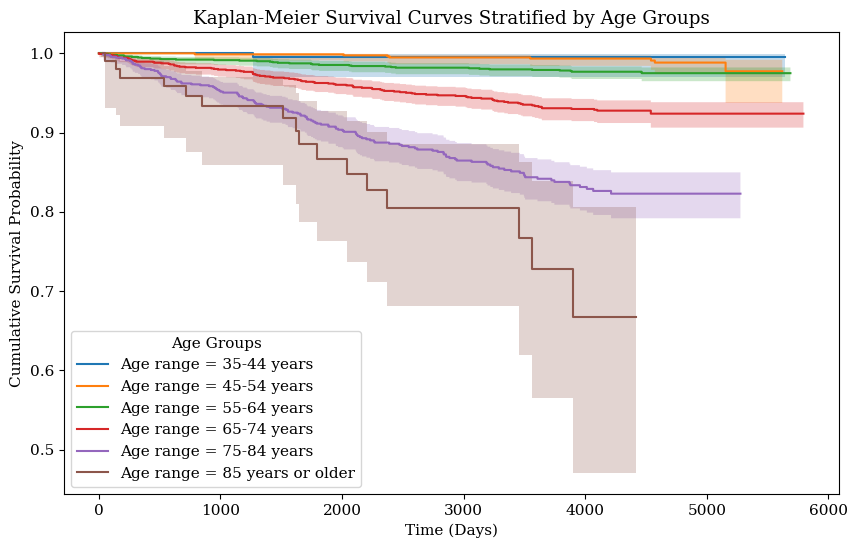

In [16]:
plt.figure(figsize=(10, 6))  # Width: 12 inches, Height: 8 inches


for age_category in data_x["age_category_s1"].unique():
    mask_treat = data_x["age_category_s1"] == age_category
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat],
        conf_type="log-log",
    )
    
    age_label = AGE_LABELS[age_category]

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Age range = {age_label}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")


# Title
plt.title("Kaplan-Meier Survival Curves Stratified by Age Groups")
# Y-axis label
plt.ylabel("Cumulative Survival Probability")
# X-axis label
plt.xlabel("Time (Days)")
# Legend title
plt.legend(title="Age Groups", loc="best")
plt.savefig("km-by-age-groups.png")

### Survival difference if already had a stroke

Log-rank test p-value: 0.0000


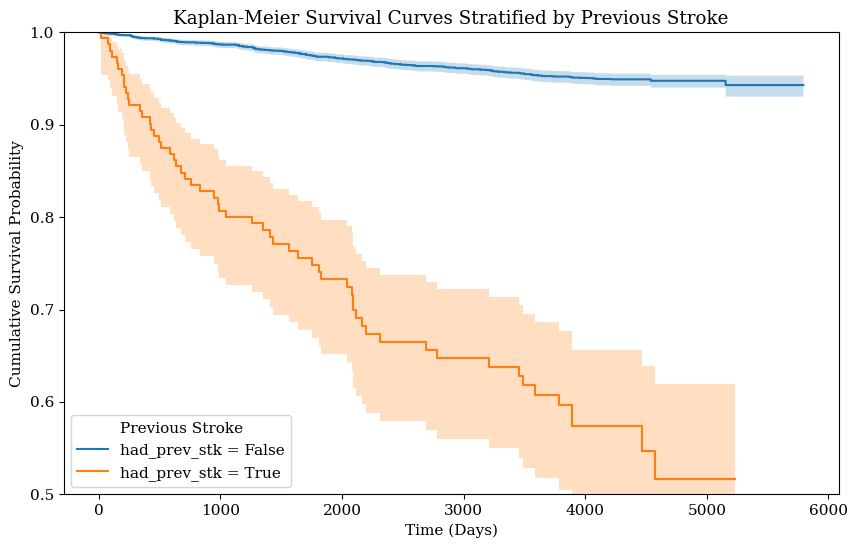

In [21]:
from lifelines.statistics import logrank_test
def kaplan_meier_plot_with_logrank(data_x, data_y, group_column, group_title, plot_name, time_column='Survival_in_days', event_column='Status'):
    """
    Create a Kaplan-Meier plot and perform a log-rank test for a binary grouping variable.
    
    :param data_x: DataFrame containing feature data
    :param data_y: DataFrame containing survival data
    :param group_column: Name of the column to group by (e.g., 'had_prev_mip')
    :param time_column: Name of the column containing survival times
    :param event_column: Name of the column containing event indicators
    """
    plt.figure(figsize=(10, 6))
    
    # Store data for log-rank test
    group_data = []
    
    # Store minimum survival probability
    min_survival_prob = float('inf')
    
    for group_value in data_x[group_column].unique():
        mask = data_x[group_column] == group_value
        time, survival_prob, conf_int = kaplan_meier_estimator(
            data_y[event_column][mask],
            data_y[time_column][mask],
            conf_type="log-log"
        )
        plt.step(time, survival_prob, where="post", label=f"{group_column} = {group_value}")
        plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
        
        # Update minimum survival probability
        min_survival_prob = min(min_survival_prob, np.min(survival_prob))
        
        # Store data for log-rank test
        group_data.append((data_y[time_column][mask], data_y[event_column][mask]))
    
    # Calculate y_min (round down to nearest 0.05)
    y_min = max(0, np.floor(min_survival_prob * 20) / 20)
    
    plt.ylim(y_min, 1)    
    # Title
    plt.title(f'Kaplan-Meier Survival Curves Stratified by {group_title}')
    # Y-axis label
    plt.ylabel("Cumulative Survival Probability")
    # X-axis label
    plt.xlabel("Time (Days)")
    # Legend title
    plt.legend(title=group_title, loc="best")
    plt.savefig(plot_name)
    
    # Perform log-rank test
    if len(group_data) == 2:
        results = logrank_test(group_data[0][0], group_data[1][0], 
                               group_data[0][1], group_data[1][1])
        print(f"Log-rank test p-value: {results.p_value:.4f}")
    else:
        print("Log-rank test requires exactly two groups for comparison.")
    
    plt.show()
    
data_x["had_prev_stk"] = data_x["prev_stk"].apply(lambda x: x > 0)
kaplan_meier_plot_with_logrank(data_x, data_y, 'had_prev_stk', "Previous Stroke", "km-by-prev-stk.png")

In [37]:
data_x.shape

(5009, 41)

In [36]:
np.sum(data_y['Status'])

285

### Gender

Log-rank test p-value: 0.2097


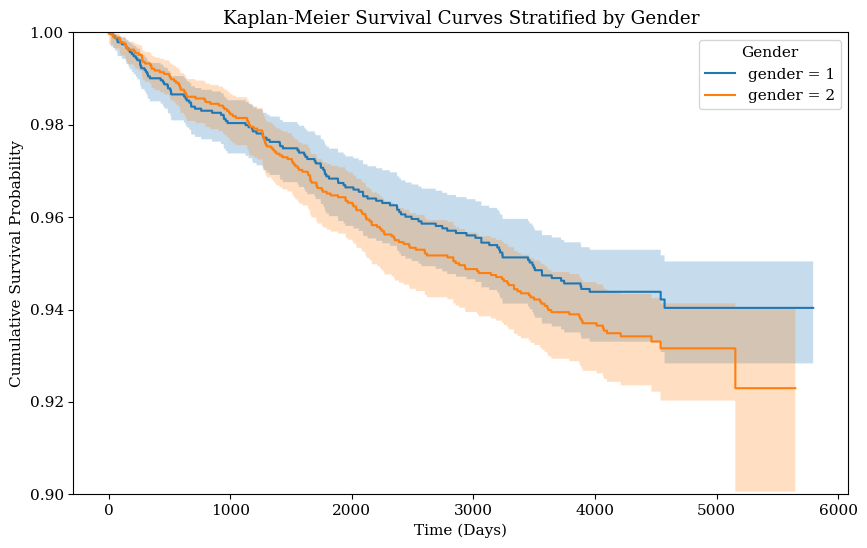

In [22]:
kaplan_meier_plot_with_logrank(data_x, data_y, 'gender', "Gender", "km-by-gender.png")

### Stratified survival plot of the features

Log-rank test results:
Stratum 1 vs Stratum 2: p-value = 0.0000
Stratum 1 vs Stratum 3: p-value = 0.0000
Stratum 2 vs Stratum 3: p-value = 0.0217


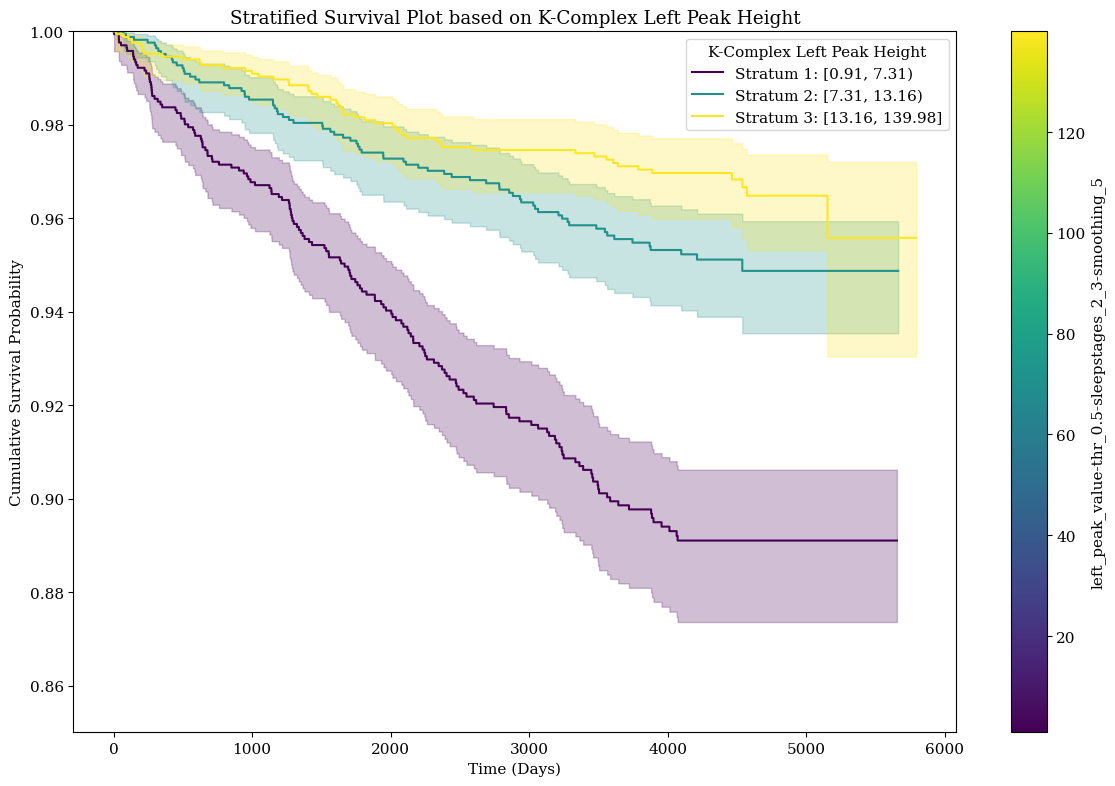

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd

def stratified_survival_plot(data_x, data_y, feature_name, group_title, plot_name, n_strata=4, time_column='Survival_in_days', event_column='Status'):
    """
    Create a stratified survival plot based on a continuous feature and perform log-rank test.
    
    :param data_x: DataFrame containing feature data
    :param data_y: DataFrame containing survival data
    :param feature_name: Name of the feature to stratify on
    :param group_title: Title for the legend
    :param plot_name: Name for saving the plot
    :param n_strata: Number of strata to create
    :param time_column: Name of the column containing survival times
    :param event_column: Name of the column containing event indicators
    """
    # Create strata based on quantiles of the feature
    strata, bins = pd.qcut(data_x[feature_name], q=n_strata, labels=False, retbins=True)
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color map for the strata
    colors = plt.cm.viridis(np.linspace(0, 1, n_strata))
    
    # Fit KM and plot for each stratum
    kmf = KaplanMeierFitter()
    all_survival_data = []
    min_survival_prob = float('inf')
    
    for i in range(n_strata):
        mask = strata == i
        if i == 0:
            stratum_range = f"[{bins[i]:.2f}, {bins[i+1]:.2f})"
        elif i == n_strata - 1:
            stratum_range = f"[{bins[i]:.2f}, {bins[i+1]:.2f}]"
        else:
            stratum_range = f"[{bins[i]:.2f}, {bins[i+1]:.2f})"
        label = f'Stratum {i+1}: {stratum_range}'
        kmf.fit(data_y[time_column][mask], data_y[event_column][mask], label=label)
        ax = kmf.plot(ax=ax, ci_show=True, color=colors[i])
        all_survival_data.append((data_y[time_column][mask], data_y[event_column][mask]))
        
        # Update minimum survival probability
        min_survival_prob = min(min_survival_prob, kmf.survival_function_.min().min())
    
    # Calculate y_min (round down to nearest 0.05)
    y_min = max(0, np.floor(min_survival_prob * 20) / 20)
    
    # Customize the plot
    ax.set_ylim(y_min, 1)
    ax.set_ylabel("Cumulative Survival Probability")
    ax.set_xlabel("Time (Days)")
    ax.set_title(f"Stratified Survival Plot based on {group_title}")
    
    # Adjust legend
    ax.legend(title=f"{group_title}", loc="best")
    
    # Add a colorbar to show the range of the feature
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=data_x[feature_name].min(), vmax=data_x[feature_name].max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(feature_name)
    
    plt.tight_layout()
    plt.savefig(plot_name, bbox_inches='tight')
    
    # Perform log-rank test
    if n_strata == 2:
        results = logrank_test(all_survival_data[0][0], all_survival_data[1][0], 
                               all_survival_data[0][1], all_survival_data[1][1])
        print(f"Log-rank test p-value: {results.p_value:.4f}")
    else:
        print("Log-rank test results:")
        for i in range(n_strata):
            for j in range(i+1, n_strata):
                results = logrank_test(all_survival_data[i][0], all_survival_data[j][0], 
                                       all_survival_data[i][1], all_survival_data[j][1])
                print(f"Stratum {i+1} vs Stratum {j+1}: p-value = {results.p_value:.4f}")
    
    plt.show()

# Example usage:
stratified_survival_plot(data_x, data_y, 'left_peak_value-thr_0.5-sleepstages_2_3-smoothing_5', "K-Complex Left Peak Height", "str-km-by-left-peak.png", n_strata=3)

Log-rank test results:
Stratum 1 vs Stratum 2: p-value = 0.0454
Stratum 1 vs Stratum 3: p-value = 0.0000
Stratum 2 vs Stratum 3: p-value = 0.0004


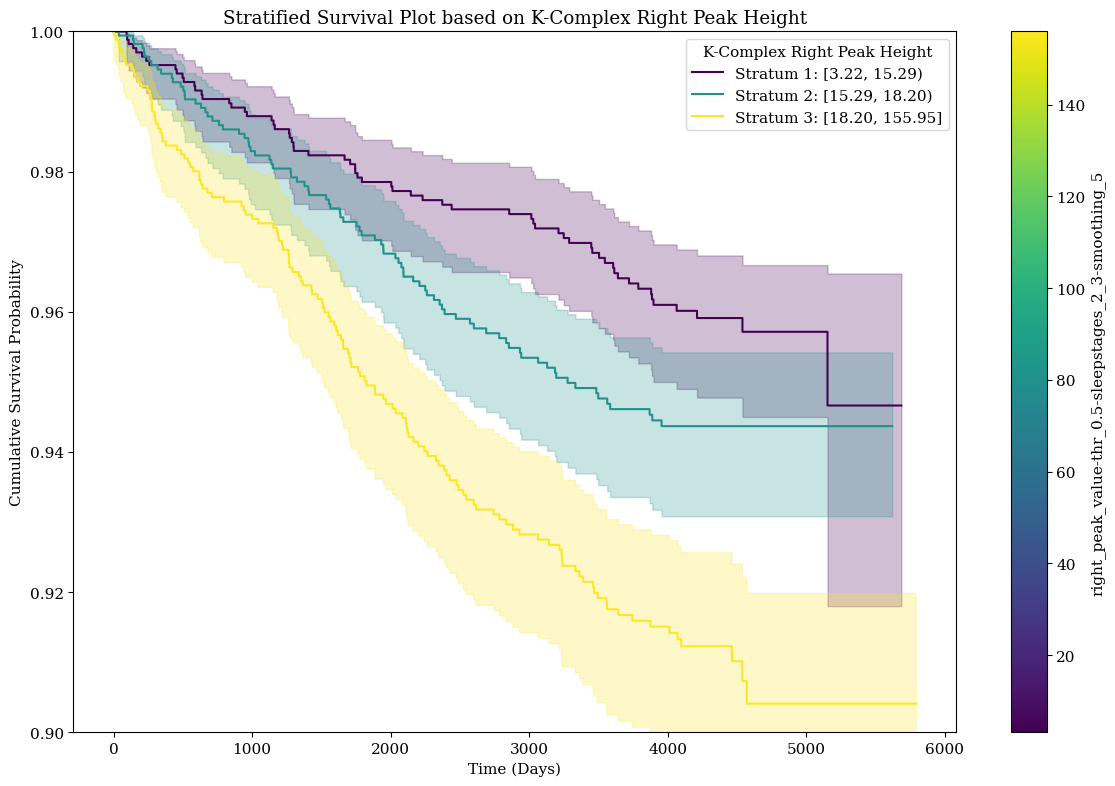

In [24]:
stratified_survival_plot(data_x, data_y, 'right_peak_value-thr_0.5-sleepstages_2_3-smoothing_5', "K-Complex Right Peak Height", "str-km-by-right-peak.png", n_strata=3)

### Stratified survival by age

Log-rank test results:
Stratum 1 vs Stratum 2: p-value = 0.0042
Stratum 1 vs Stratum 3: p-value = 0.0013
Stratum 1 vs Stratum 4: p-value = 0.0000
Stratum 1 vs Stratum 5: p-value = 0.0000
Stratum 1 vs Stratum 6: p-value = 0.0000
Stratum 2 vs Stratum 3: p-value = 0.6716
Stratum 2 vs Stratum 4: p-value = 0.0023
Stratum 2 vs Stratum 5: p-value = 0.0000
Stratum 2 vs Stratum 6: p-value = 0.0000
Stratum 3 vs Stratum 4: p-value = 0.0065
Stratum 3 vs Stratum 5: p-value = 0.0000
Stratum 3 vs Stratum 6: p-value = 0.0000
Stratum 4 vs Stratum 5: p-value = 0.0000
Stratum 4 vs Stratum 6: p-value = 0.0000
Stratum 5 vs Stratum 6: p-value = 0.0002


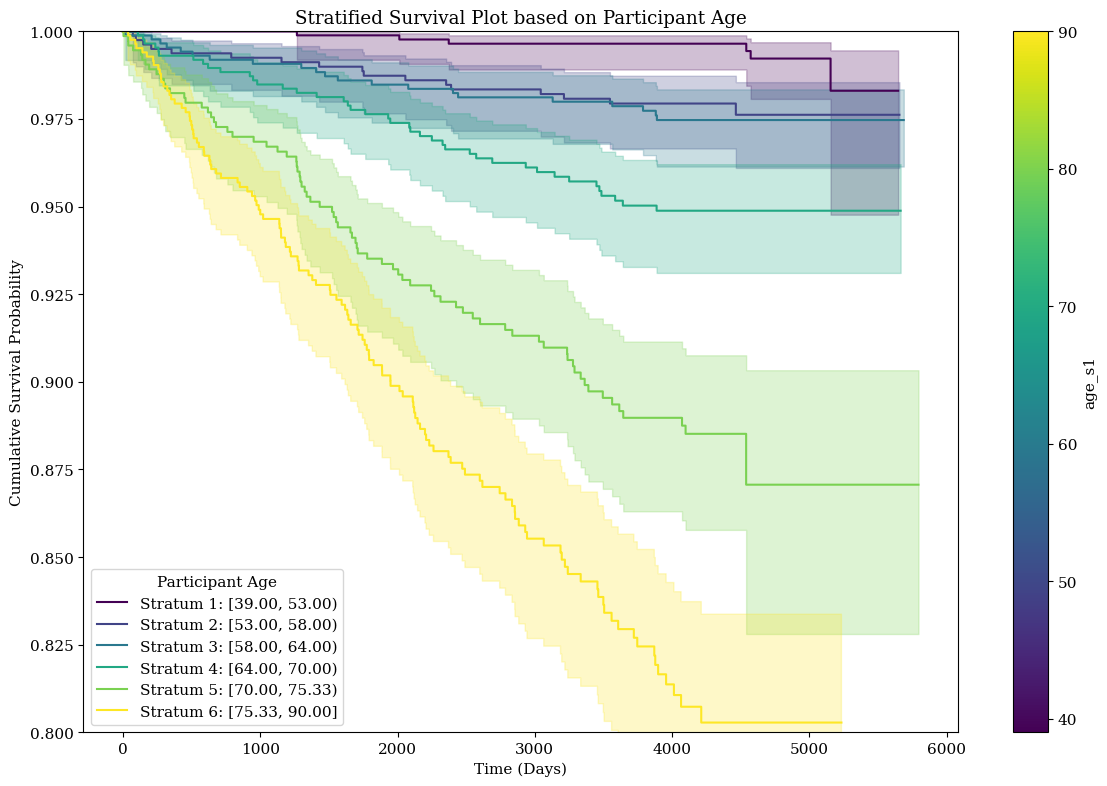

In [25]:
stratified_survival_plot(data_x, data_y, 'age_s1',"Participant Age", "str-km-by-age.png", n_strata=6)

### Survival Regression
- Use Sleep Stages 2 and 3 to have effect of both left and right peak values.
- Use Threshold of 0.5 for max impact of right peak
- Feature Variables:
    - right peak value
    - left peak value
- Controlling variables:
    - age
    - prev_stk (most important feature)
    - still added gender to it

In [22]:
# Rename the features
data_x_surv = data_x.rename(columns={"right_peak_value-thr_0.5-sleepstages_2_3-smoothing_5": "right_peak_height"})
data_x_surv = data_x_surv.rename(columns={"left_peak_value-thr_0.5-sleepstages_2_3-smoothing_5": "left_peak_height"})

In [23]:
features = ["left_peak_height", "right_peak_height"]
controlling_variables = ["age_s1", "had_prev_stk", "gender"]

In [24]:
data_x_surv = data_x_surv[controlling_variables + features]
data_x_surv.head()

,age_s1,had_prev_stk,gender,left_peak_height,right_peak_height
76,41.0,False,1,13.205370,9.238895
77,54.0,False,1,15.962061,15.984036
78,56.0,False,2,22.892030,15.176667
79,54.0,False,1,24.257517,9.391896
80,40.0,False,2,18.654047,12.289632


In [25]:
data_y_sksurv = data_y

### Look at correlation of only these features again

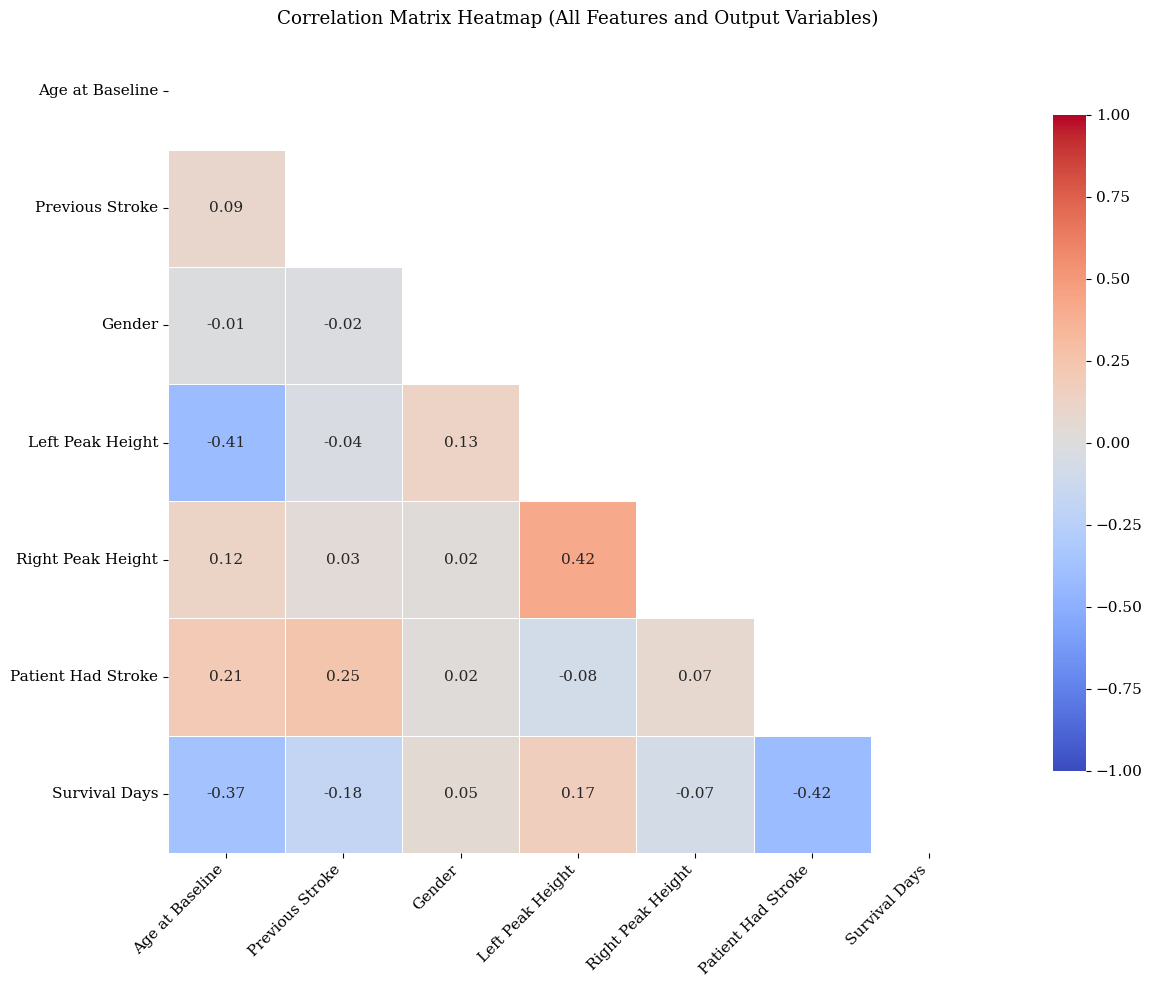

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_correlation_heatmap(data_x, data_y, output_file=None, column_mapping=None):
    # Convert data_y to a DataFrame
    data_y_df = pd.DataFrame(data_y)
    
    # Concatenate data_x and data_y
    combined_data = pd.concat([data_x.reset_index(drop=True), data_y_df.reset_index(drop=True)], axis=1)
    
    # Apply column mapping if provided
    if column_mapping:
        combined_data = combined_data.rename(columns=column_mapping)
    
    # Calculate the correlation matrix
    correlation_matrix = combined_data.corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 10))
    
    # Create a heatmap of the correlation matrix
    sns.heatmap(correlation_matrix, 
                annot=True,  # Add correlation values in the squares
                fmt='.2f',   # Format correlation values to 2 decimal places
                cmap='coolwarm', 
                vmin=-1, 
                vmax=1, 
                center=0,
                square=True,  # Make sure the cells are square
                linewidths=.5,  # Add lines between cells
                cbar_kws={"shrink": .8},  # Shrink the colorbar slightly
                mask=mask)  # Apply the mask to show only the lower triangle
    
    plt.title('Correlation Matrix Heatmap (All Features and Output Variables)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    plt.show()

# Example column mapping
column_mapping = {
    'age_s1': 'Age at Baseline',
    'had_prev_stk': 'Previous Stroke',
    'gender': 'Gender',
    'left_peak_height': 'Left Peak Height',
    'right_peak_height': 'Right Peak Height',
    'Status': 'Patient Had Stroke',
    'Survival_in_days': 'Survival Days'
}

# Use the function with the mapping
plot_correlation_heatmap(data_x_surv, data_y, 'correlation_matrix_heatmap.png', column_mapping)

### Utils function to convert y label to lifeline format

In [27]:
def convert_to_lifelines_format(data_x, data_y_sksurv):
    """
    Convert data from sksurv format to lifelines format.
    
    :param data_x: DataFrame containing the features
    :param data_y_sksurv: Structured array containing the survival data in sksurv format
    :return: DataFrame with features and survival data in lifelines format
    """
    # Extract time and event data from the structured array
    time = data_y_sksurv['Survival_in_days']
    event = data_y_sksurv['Status']
    
    # Create a new DataFrame with survival data
    survival_data = pd.DataFrame({
        'duration': time,
        'event': event
    })
    
    # Combine feature data with survival data
    combined_data = pd.concat([data_x.reset_index(drop=True), survival_data], axis=1)
    
    return combined_data

In [28]:
data_x_surv = convert_to_lifelines_format(data_x_surv, data_y_sksurv)
# Add a small value (e.g., 0.1) to all durations
data_x_surv['duration'] = data_x_surv['duration'] + 0.1

### Fit Cox Regression

In [29]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np

def fit_cox_model_and_interpret(data, duration_col, event_col, features, controlling_variables):
    """
    Fit a Cox Proportional Hazards model, interpret the results, and estimate performance on training data.
    
    :param data: DataFrame containing all variables
    :param duration_col: Name of the column containing duration data
    :param event_col: Name of the column containing event data
    :param features: List of main features of interest
    :param controlling_variables: List of controlling variables
    :return: Fitted CoxPHFitter model and performance metrics
    """
    # Combine features and controlling variables
    all_variables = features + controlling_variables
    
    # Select only the required columns
    data_for_model = data[[duration_col, event_col] + all_variables]
    
    # Fit the Cox model
    cph = CoxPHFitter(penalizer=0.05)
    cph.fit(data_for_model, duration_col=duration_col, event_col=event_col)
    
    # Print the summary
    print(cph.print_summary())
    
    # Calculate and print hazard ratios with confidence intervals
    print("\nHazard Ratios:")
    hazard_ratios = np.exp(cph.params_)
    conf_intervals = np.exp(cph.confidence_intervals_)
    for variable in all_variables:
        hr = hazard_ratios[variable]
        ci_lower, ci_upper = conf_intervals.loc[variable]
        print(f"{variable}: {hr:.3f} (95% CI: {ci_lower:.3f} - {ci_upper:.3f})")
    
    # Calculate performance metrics
    c_index = concordance_index(data_for_model[duration_col], -cph.predict_partial_hazard(data_for_model), data_for_model[event_col])
    log_likelihood = cph.log_likelihood_
    aic_partial = cph.AIC_partial_
    r_squared = cph.score(data_for_model, scoring_method="concordance_index")
    
    # Calculate log-rank test
    median_prediction = np.median(cph.predict_partial_hazard(data_for_model))
    low_risk = data_for_model[cph.predict_partial_hazard(data_for_model) < median_prediction]
    high_risk = data_for_model[cph.predict_partial_hazard(data_for_model) >= median_prediction]
    log_rank_result = logrank_test(low_risk[duration_col], high_risk[duration_col], 
                                   low_risk[event_col], high_risk[event_col])
    
    # Print results with ranges and interpretations
    print("\nPerformance Metrics:")
    print(f"1. Concordance Index: {c_index:.3f}")
    print("   Range: 0.5 to 1.0")
    print("   Interpretation: 0.5 = random predictions, 1.0 = perfect predictions")
    print("   Rule of thumb: >0.7 good, >0.8 excellent")
    
    print(f"\n2. Log-likelihood: {log_likelihood:.3f}")
    print("   Range: -∞ to 0")
    print("   Interpretation: Higher (closer to 0) is better")
    print("   Note: Useful for comparing models on the same data")
    
    print(f"\n3. Partial AIC: {aic_partial:.3f}")
    print("   Range: 0 to +∞")
    print("   Interpretation: Lower is better (balances fit and complexity)")
    print("   Note: Useful for comparing models with different numbers of predictors")
    
    print(f"\n4. R-squared (explained variation): {r_squared:.3f}")
    print("   Range: 0 to 1")
    print("   Interpretation: Higher is better, represents proportion of variance explained")
    print("   Note: In survival analysis, even relatively low values can be meaningful")
    
    print(f"\n5. Log-rank test p-value: {log_rank_result.p_value:.6f}")
    print("   Range: 0 to 1")
    print("   Interpretation: <0.05 suggests significant difference between risk groups")
    print("   Note: Tests if model significantly distinguishes between high and low risk")
    
    return cph, c_index, log_likelihood, aic_partial, r_squared, log_rank_result.p_value

### Regression wiht both features

In [30]:
reg_features = ["right_peak_height", "left_peak_height"]
reg_controlling_variables = ["age_s1", "had_prev_stk", "gender"]

model, c_index, log_likelihood, aic_partial, r_squared, log_rank_p = fit_cox_model_and_interpret(data_x_surv, 'duration', 'event', reg_features, reg_controlling_variables)

<lifelines.CoxPHFitter: fitted with 5009 total observations, 4724 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5009
number of events observed = 285
   partial log-likelihood = -2251.16
         time fit was run = 2024-08-22 09:49:32 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
right_peak_height  0.02      1.02      0.00            0.01            0.03                1.01                1.03
left_peak_height  -0.02      0.98      0.01           -0.03           -0.01                0.97                0.99
age_s1             0.04      1.04      0.00            0.03            0.05                1.03                1.05
had_prev_stk       1.86      6.42      0.15            1.56            2.16                4.78                8.63
gender             0.10      1.10      0.09           -0.07            0.27                0.93                1.31

                   cmp to     z      p  -log2(p)
covariate                                       
right_peak_height    0.00  3.79 <0.005     12.72
left_peak_height     0.00 -2.88 <0.005      7.95
age_s1               0.00  9.98 <0.005     75.52
had_prev_stk         0.00 12.31 <0.005    113.34
gender               0.00  1.11   0.27      1.91
---
Concordance = 0.84
Partial AIC = 4512.32
log-likelihood ratio test = 268.82 on 5 df
-log2(p) of ll-ratio test = 183.70

None

Hazard Ratios:
right_peak_height: 1.018 (95% CI: 1.008 - 1.027)
left_peak_height: 0.984 (95% CI: 0.973 - 0.995)
age_s1: 1.043 (95% CI: 1.034 - 1.051)
had_prev_stk: 6.420 (95% CI: 4.775 - 8.631)
gender: 1.102 (95% CI: 0.929 - 1.307)

Performance Metrics:
1. Concordance Index: 0.835
   Range: 0.5 to 1.0
   Interpretation: 0.5 = random predictions, 1.0 = perfect predictions
   Rule of thumb: >0.7 good, >0.8 excellent

2. Log-likelihood: -2251.162
   Range: -∞ to 0
   Interpretation: Higher (closer to 0) is better
   Note: Useful for comparing models on the same data

3. Partial AIC: 4512.324
   Range: 0 to +∞
   Interpretation: Lower is better (balances fit and complexity)
   Note: Useful for comparing models with different numbers of predictors

4. R-squared (explained variation): 0.835
   Range: 0 to 1
   Interpretation: Higher is better, represents proportion of variance explained
   Note: In survival analysis, even relatively low values can be meaningful

5. Log-rank test p-valu

### Regression with only right peak

In [31]:
reg_features = ["right_peak_height"]
reg_controlling_variables = ["age_s1", "had_prev_stk", "gender"]

model, c_index, log_likelihood, aic_partial, r_squared, log_rank_p = fit_cox_model_and_interpret(data_x_surv, 'duration', 'event', reg_features, reg_controlling_variables)

<lifelines.CoxPHFitter: fitted with 5009 total observations, 4724 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5009
number of events observed = 285
   partial log-likelihood = -2255.50
         time fit was run = 2024-08-22 09:49:32 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
right_peak_height  0.01      1.01      0.00            0.00            0.02                1.00                1.02
age_s1             0.04      1.05      0.00            0.04            0.05                1.04                1.05
had_prev_stk       1.88      6.58      0.15            1.59            2.18                4.89                8.85
gender             0.08      1.09      0.09           -0.09            0.25                0.92                1.29

                   cmp to     z      p  -log2(p)
covariate                                       
right_peak_height    0.00  3.08 <0.005      8.91
age_s1               0.00 10.82 <0.005     88.29
had_prev_stk         0.00 12.48 <0.005    116.28
gender               0.00  0.96   0.34      1.57
---
Concordance = 0.83
Partial AIC = 4519.00
log-likelihood ratio test = 260.15 on 4 df
-log2(p) of ll-ratio test = 180.62

None

Hazard Ratios:
right_peak_height: 1.012 (95% CI: 1.004 - 1.020)
age_s1: 1.045 (95% CI: 1.037 - 1.054)
had_prev_stk: 6.580 (95% CI: 4.895 - 8.847)
gender: 1.087 (95% CI: 0.917 - 1.289)

Performance Metrics:
1. Concordance Index: 0.831
   Range: 0.5 to 1.0
   Interpretation: 0.5 = random predictions, 1.0 = perfect predictions
   Rule of thumb: >0.7 good, >0.8 excellent

2. Log-likelihood: -2255.498
   Range: -∞ to 0
   Interpretation: Higher (closer to 0) is better
   Note: Useful for comparing models on the same data

3. Partial AIC: 4518.995
   Range: 0 to +∞
   Interpretation: Lower is better (balances fit and complexity)
   Note: Useful for comparing models with different numbers of predictors

4. R-squared (explained variation): 0.831
   Range: 0 to 1
   Interpretation: Higher is better, represents proportion of variance explained
   Note: In survival analysis, even relatively low values can be meaningful

5. Log-rank test p-value: 0.000000
   Range: 0 to 1
   Interpretation: 

### Regression with only left peak

In [32]:
reg_features = ["left_peak_height"]
reg_controlling_variables = ["age_s1", "had_prev_stk", "gender"]

model, c_index, log_likelihood, aic_partial, r_squared, log_rank_p = fit_cox_model_and_interpret(data_x_surv, 'duration', 'event', reg_features, reg_controlling_variables)

<lifelines.CoxPHFitter: fitted with 5009 total observations, 4724 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5009
number of events observed = 285
   partial log-likelihood = -2257.24
         time fit was run = 2024-08-22 09:49:33 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
left_peak_height -0.01      0.99      0.01           -0.02           -0.00                0.98                1.00
age_s1            0.04      1.04      0.00            0.03            0.05                1.04                1.05
had_prev_stk      1.88      6.55      0.15            1.58            2.18                4.87                8.81
gender            0.10      1.11      0.09           -0.07            0.27                0.93                1.31

                  cmp to     z      p  -log2(p)
covariate                                      
left_peak_height    0.00 -2.03   0.04      4.58
age_s1              0.00 10.34 <0.005     80.78
had_prev_stk        0.00 12.44 <0.005    115.67
gender              0.00  1.15   0.25      2.01
---
Concordance = 0.83
Partial AIC = 4522.49
log-likelihood ratio test = 256.66 on 4 df
-log2(p) of ll-ratio test = 178.12

None

Hazard Ratios:
left_peak_height: 0.988 (95% CI: 0.977 - 1.000)
age_s1: 1.044 (95% CI: 1.036 - 1.053)
had_prev_stk: 6.552 (95% CI: 4.873 - 8.810)
gender: 1.106 (95% CI: 0.932 - 1.311)

Performance Metrics:
1. Concordance Index: 0.830
   Range: 0.5 to 1.0
   Interpretation: 0.5 = random predictions, 1.0 = perfect predictions
   Rule of thumb: >0.7 good, >0.8 excellent

2. Log-likelihood: -2257.243
   Range: -∞ to 0
   Interpretation: Higher (closer to 0) is better
   Note: Useful for comparing models on the same data

3. Partial AIC: 4522.485
   Range: 0 to +∞
   Interpretation: Lower is better (balances fit and complexity)
   Note: Useful for comparing models with different numbers of predictors

4. R-squared (explained variation): 0.830
   Range: 0 to 1
   Interpretation: Higher is better, represents proportion of variance explained
   Note: In survival analysis, even relatively low values can be meaningful

5. Log-rank test p-value: 0.000000
   Range: 0 to 1
   Interpretation: <

### Subgroup Analysis
- For male, Concordance Index: 0.804
    - Data for male generally a bit more variance that cannot be explained by the model
- For female, Concordance Index: 0.859

In [33]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np

def cox_regression_gender_subgroup(data, duration_col, event_col, features, controlling_variables):
    """
    Perform Cox regression analysis separately for male and female subgroups.
    
    :param data: DataFrame containing all variables
    :param duration_col: Name of the column containing duration data
    :param event_col: Name of the column containing event data
    :param features: List of main features of interest
    :param controlling_variables: List of controlling variables (excluding gender)
    :return: Dictionary containing results for each gender
    """
    def fit_model(df):
        # Combine features and controlling variables
        all_variables = features + controlling_variables
        # Select only the required columns
        data_for_model = df[[duration_col, event_col] + all_variables]
        # Fit the Cox model
        cph = CoxPHFitter(penalizer=0.0001)
        cph.fit(data_for_model, duration_col=duration_col, event_col=event_col)
        return cph, data_for_model

    def print_results(model, gender, data_for_model):
        print(f"\n--- Results for {gender} ---")
        print(model.print_summary())
        
        print("\nHazard Ratios:")
        hazard_ratios = np.exp(model.params_)
        conf_intervals = np.exp(model.confidence_intervals_)
        for variable in model.params_.index:
            hr = hazard_ratios[variable]
            ci_lower, ci_upper = conf_intervals.loc[variable]
            print(f"{variable}: {hr:.3f} (95% CI: {ci_lower:.3f} - {ci_upper:.3f})")
        
        # Calculate performance metrics
        c_index = concordance_index(data_for_model[duration_col], -model.predict_partial_hazard(data_for_model), data_for_model[event_col])
        log_likelihood = model.log_likelihood_
        aic_partial = model.AIC_partial_
        r_squared = model.score(data_for_model, scoring_method="concordance_index")
        
        # Calculate log-rank test
        median_prediction = np.median(model.predict_partial_hazard(data_for_model))
        low_risk = data_for_model[model.predict_partial_hazard(data_for_model) < median_prediction]
        high_risk = data_for_model[model.predict_partial_hazard(data_for_model) >= median_prediction]
        log_rank_result = logrank_test(low_risk[duration_col], high_risk[duration_col], 
                                       low_risk[event_col], high_risk[event_col])
        
        # Print performance metrics with ranges and interpretations
        print("\nPerformance Metrics:")
        print(f"1. Concordance Index: {c_index:.3f}")
        print("   Range: 0.5 to 1.0")
        print("   Interpretation: 0.5 = random predictions, 1.0 = perfect predictions")
        print("   Rule of thumb: >0.7 good, >0.8 excellent")
        
        print(f"\n2. Log-likelihood: {log_likelihood:.3f}")
        print("   Range: -∞ to 0")
        print("   Interpretation: Higher (closer to 0) is better")
        print("   Note: Useful for comparing models on the same data")
        
        print(f"\n3. Partial AIC: {aic_partial:.3f}")
        print("   Range: 0 to +∞")
        print("   Interpretation: Lower is better (balances fit and complexity)")
        print("   Note: Useful for comparing models with different numbers of predictors")
        
        print(f"\n4. R-squared (explained variation): {r_squared:.3f}")
        print("   Range: 0 to 1")
        print("   Interpretation: Higher is better, represents proportion of variance explained")
        print("   Note: In survival analysis, even relatively low values can be meaningful")
        
        print(f"\n5. Log-rank test p-value: {log_rank_result.p_value:.6f}")
        print("   Range: 0 to 1")
        print("   Interpretation: <0.05 suggests significant difference between risk groups")
        print("   Note: Tests if model significantly distinguishes between high and low risk")
        
        return c_index, log_likelihood, aic_partial, r_squared, log_rank_result.p_value

    # Ensure gender is binary (1 or 2)
    data['gender'] = data['gender'].astype(int)
    # Split data by gender
    male_data = data[data['gender'] == 1]
    female_data = data[data['gender'] == 2]
    
    # Fit models for each gender
    male_model, male_data_for_model = fit_model(male_data)
    female_model, female_data_for_model = fit_model(female_data)
    
    # Print results and get performance metrics
    male_metrics = print_results(male_model, "Male", male_data_for_model)
    female_metrics = print_results(female_model, "Female", female_data_for_model)
    
    return {
        "male": {"model": male_model, "metrics": male_metrics},
        "female": {"model": female_model, "metrics": female_metrics}
    }

In [34]:
# Gender
reg_features = ["right_peak_height", "left_peak_height"]
reg_controlling_variables = ["age_s1", "had_prev_stk"]

results = cox_regression_gender_subgroup(data_x_surv, 'duration', 'event', reg_features, reg_controlling_variables)


--- Results for Male ---


<lifelines.CoxPHFitter: fitted with 2333 total observations, 2213 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2333
number of events observed = 120
   partial log-likelihood = -838.76
         time fit was run = 2024-08-22 09:49:33 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
right_peak_height  0.02      1.02      0.01            0.00            0.05                1.00                1.05
left_peak_height  -0.02      0.98      0.02           -0.05            0.02                0.95                1.02
age_s1             0.07      1.08      0.01            0.05            0.10                1.05                1.10
had_prev_stk       2.16      8.65      0.22            1.72            2.59                5.60               13.36

                   cmp to     z      p  -log2(p)
covariate                                       
right_peak_height    0.00  2.05   0.04      4.62
left_peak_height     0.00 -0.98   0.33      1.61
age_s1               0.00  6.80 <0.005     36.49
had_prev_stk         0.00  9.73 <0.005     71.96
---
Concordance = 0.80
Partial AIC = 1685.51
log-likelihood ratio test = 147.75 on 4 df
-log2(p) of ll-ratio test = 100.35

None

Hazard Ratios:
right_peak_height: 1.024 (95% CI: 1.001 - 1.047)
left_peak_height: 0.985 (95% CI: 0.955 - 1.016)
age_s1: 1.078 (95% CI: 1.055 - 1.101)
had_prev_stk: 8.650 (95% CI: 5.602 - 13.357)

Performance Metrics:
1. Concordance Index: 0.804
   Range: 0.5 to 1.0
   Interpretation: 0.5 = random predictions, 1.0 = perfect predictions
   Rule of thumb: >0.7 good, >0.8 excellent

2. Log-likelihood: -838.756
   Range: -∞ to 0
   Interpretation: Higher (closer to 0) is better
   Note: Useful for comparing models on the same data

3. Partial AIC: 1685.511
   Range: 0 to +∞
   Interpretation: Lower is better (balances fit and complexity)
   Note: Useful for comparing models with different numbers of predictors

4. R-squared (explained variation): 0.804
   Range: 0 to 1
   Interpretation: Higher is better, represents proportion of variance explained
   Note: In survival analysis, even relatively low values can be meaningful

5. Log-rank test p-value: 0.000000
   Range: 0 to 1
   Interp

<lifelines.CoxPHFitter: fitted with 2676 total observations, 2511 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2676
number of events observed = 165
   partial log-likelihood = -4370.99
         time fit was run = 2024-08-22 09:49:34 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
right_peak_height  0.03      1.03      0.01            0.01            0.04                1.01                1.04
left_peak_height  -0.02      0.98      0.02           -0.05            0.02                0.95                1.02
age_s1             0.09      1.09      0.01            0.07            0.11                1.07                1.11
had_prev_stk      28.14  1.66e+12     11.71            5.19           51.09              179.05            1.54e+22

                   cmp to     z      p  -log2(p)
covariate                                       
right_peak_height    0.00  3.02 <0.005      8.61
left_peak_height     0.00 -1.00   0.32      1.66
age_s1               0.00  8.00 <0.005     49.47
had_prev_stk         0.00  2.40   0.02      5.94
---
Concordance = 0.86
Partial AIC = 8749.98
log-likelihood ratio test = -6185.29 on 4 df
-log2(p) of ll-ratio test = -0.00

None

Hazard Ratios:
right_peak_height: 1.025 (95% CI: 1.009 - 1.042)
left_peak_height: 0.984 (95% CI: 0.955 - 1.015)
age_s1: 1.090 (95% CI: 1.067 - 1.113)
had_prev_stk: 1661985411264.500 (95% CI: 179.045 - 15427344029415091732480.000)

Performance Metrics:
1. Concordance Index: 0.857
   Range: 0.5 to 1.0
   Interpretation: 0.5 = random predictions, 1.0 = perfect predictions
   Rule of thumb: >0.7 good, >0.8 excellent

2. Log-likelihood: -4370.991
   Range: -∞ to 0
   Interpretation: Higher (closer to 0) is better
   Note: Useful for comparing models on the same data

3. Partial AIC: 8749.983
   Range: 0 to +∞
   Interpretation: Lower is better (balances fit and complexity)
   Note: Useful for comparing models with different numbers of predictors

4. R-squared (explained variation): 0.857
   Range: 0 to 1
   Interpretation: Higher is better, represents proportion of variance explained
   Note: In survival analysis, even relatively low values can be meaningful

5. Log-rank test p-value:

### Subgroup analysis Age

In [35]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np

def cox_regression_age_subgroup(data, duration_col, event_col, features, controlling_variables, num_quantiles=4):
    """
    Perform Cox regression analysis separately for age subgroups.
    
    :param data: DataFrame containing all variables
    :param duration_col: Name of the column containing duration data
    :param event_col: Name of the column containing event data
    :param features: List of main features of interest
    :param controlling_variables: List of controlling variables (excluding age_s1)
    :param num_quantiles: Number of age groups to create (default is 4 for quartiles)
    :return: Dictionary containing results for each age group
    """
    def fit_model(df):
        all_variables = features + controlling_variables
        data_for_model = df[[duration_col, event_col] + all_variables]
        cph = CoxPHFitter(penalizer=0.0001)
        cph.fit(data_for_model, duration_col=duration_col, event_col=event_col)
        return cph, data_for_model

    def print_results(model, age_group, data_for_model):
        print(f"\n--- Results for Age Group: {age_group} ---")
        print(model.print_summary())
        
        print("\nHazard Ratios:")
        hazard_ratios = np.exp(model.params_)
        conf_intervals = np.exp(model.confidence_intervals_)
        for variable in model.params_.index:
            hr = hazard_ratios[variable]
            ci_lower, ci_upper = conf_intervals.loc[variable]
            print(f"{variable}: {hr:.3f} (95% CI: {ci_lower:.3f} - {ci_upper:.3f})")
        
        c_index = concordance_index(data_for_model[duration_col], -model.predict_partial_hazard(data_for_model), data_for_model[event_col])
        log_likelihood = model.log_likelihood_
        aic_partial = model.AIC_partial_
        r_squared = model.score(data_for_model, scoring_method="concordance_index")
        
        median_prediction = np.median(model.predict_partial_hazard(data_for_model))
        low_risk = data_for_model[model.predict_partial_hazard(data_for_model) < median_prediction]
        high_risk = data_for_model[model.predict_partial_hazard(data_for_model) >= median_prediction]
        log_rank_result = logrank_test(low_risk[duration_col], high_risk[duration_col], 
                                       low_risk[event_col], high_risk[event_col])
        
        print("\nPerformance Metrics:")
        print(f"1. Concordance Index: {c_index:.3f}")
        print(f"2. Log-likelihood: {log_likelihood:.3f}")
        print(f"3. Partial AIC: {aic_partial:.3f}")
        print(f"4. R-squared: {r_squared:.3f}")
        print(f"5. Log-rank test p-value: {log_rank_result.p_value:.6f}")
        
        return c_index, log_likelihood, aic_partial, r_squared, log_rank_result.p_value
    
    data = data.copy(deep = True)
    # Create age groups
    data['age_group'] = pd.qcut(data['age_s1'], q=num_quantiles, labels=False)
    
    results = {}
    
    for group in range(num_quantiles):
        group_data = data[data['age_group'] == group]
        group_model, group_data_for_model = fit_model(group_data)
        age_range = data[data['age_group'] == group]['age_s1'].agg(['min', 'max'])
        group_name = f"Age {age_range['min']:.1f}-{age_range['max']:.1f}"
        group_metrics = print_results(group_model, group_name, group_data_for_model)
        results[group_name] = {"model": group_model, "metrics": group_metrics}
    
    return results

# Gender
reg_features = ["right_peak_height", "left_peak_height"]
reg_controlling_variables = ["gender", "had_prev_stk"]

results = cox_regression_age_subgroup(data_x_surv, 'duration', 'event', reg_features, reg_controlling_variables, num_quantiles=6)


--- Results for Age Group: Age 39.0-53.0 ---


<lifelines.CoxPHFitter: fitted with 899 total observations, 893 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 899
number of events observed = 6
   partial log-likelihood = -311.18
         time fit was run = 2024-08-22 09:49:34 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
right_peak_height   -0.06      0.94      0.08           -0.22            0.09                0.80                1.10
left_peak_height     0.08      1.08      0.05           -0.02            0.18                0.98                1.20
gender              -1.99      0.14      1.05           -4.05            0.07                0.02                1.07
had_prev_stk      -244.71      0.00     30.32         -304.14         -185.28                0.00                0.00

                   cmp to     z      p  -log2(p)
covariate                                       
right_peak_height    0.00 -0.80   0.42      1.24
left_peak_height     0.00  1.52   0.13      2.95
gender               0.00 -1.89   0.06      4.10
had_prev_stk         0.00 -8.07 <0.005     50.35
---
Concordance = 0.75
Partial AIC = 630.35
log-likelihood ratio test = -547.91 on 4 df
-log2(p) of ll-ratio test = -0.00

None

Hazard Ratios:
right_peak_height: 0.937 (95% CI: 0.800 - 1.099)
left_peak_height: 1.082 (95% CI: 0.977 - 1.198)
gender: 0.136 (95% CI: 0.017 - 1.072)
had_prev_stk: 0.000 (95% CI: 0.000 - 0.000)

Performance Metrics:
1. Concordance Index: 0.745
2. Log-likelihood: -311.177
3. Partial AIC: 630.354
4. R-squared: 0.745
5. Log-rank test p-value: 0.092575

--- Results for Age Group: Age 54.0-58.0 ---


<lifelines.CoxPHFitter: fitted with 803 total observations, 786 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 803
number of events observed = 17
   partial log-likelihood = -3975.45
         time fit was run = 2024-08-22 09:49:34 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
right_peak_height   -0.01      0.99      0.04           -0.08            0.07                0.93                1.07
left_peak_height    -0.00      1.00      0.03           -0.07            0.06                0.93                1.07
gender               0.70      2.01      0.55           -0.38            1.77                0.69                5.87
had_prev_stk      -463.19      0.00     26.05         -514.24         -412.13                0.00                0.00

                   cmp to      z      p  -log2(p)
covariate                                        
right_peak_height    0.00  -0.16   0.88      0.19
left_peak_height     0.00  -0.08   0.94      0.09
gender               0.00   1.27   0.20      2.30
had_prev_stk         0.00 -17.78 <0.005    232.57
---
Concordance = 0.35
Partial AIC = 7958.91
log-likelihood ratio test = -7726.80 on 4 df
-log2(p) of ll-ratio test = -0.00

None

Hazard Ratios:
right_peak_height: 0.994 (95% CI: 0.926 - 1.068)
left_peak_height: 0.997 (95% CI: 0.933 - 1.066)
gender: 2.008 (95% CI: 0.687 - 5.872)
had_prev_stk: 0.000 (95% CI: 0.000 - 0.000)

Performance Metrics:
1. Concordance Index: 0.348
2. Log-likelihood: -3975.453
3. Partial AIC: 7958.907
4. R-squared: 0.348
5. Log-rank test p-value: 0.204645

--- Results for Age Group: Age 59.0-64.0 ---


<lifelines.CoxPHFitter: fitted with 867 total observations, 846 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 867
number of events observed = 21
   partial log-likelihood = -4610.38
         time fit was run = 2024-08-22 09:49:34 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
right_peak_height    0.00      1.00      0.04           -0.07            0.07                0.94                1.07
left_peak_height    -0.01      0.99      0.04           -0.09            0.06                0.92                1.06
gender              -0.56      0.57      0.46           -1.47            0.35                0.23                1.42
had_prev_stk      -429.07      0.00     22.61         -473.39         -384.76                0.00                0.00

                   cmp to      z      p  -log2(p)
covariate                                        
right_peak_height    0.00   0.05   0.96      0.05
left_peak_height     0.00  -0.35   0.72      0.47
gender               0.00  -1.21   0.23      2.14
had_prev_stk         0.00 -18.98 <0.005    264.36
---
Concordance = 0.37
Partial AIC = 9228.77
log-likelihood ratio test = -8938.94 on 4 df
-log2(p) of ll-ratio test = -0.00

None

Hazard Ratios:
right_peak_height: 1.002 (95% CI: 0.935 - 1.073)
left_peak_height: 0.987 (95% CI: 0.917 - 1.062)
gender: 0.572 (95% CI: 0.231 - 1.417)
had_prev_stk: 0.000 (95% CI: 0.000 - 0.000)

Performance Metrics:
1. Concordance Index: 0.375
2. Log-likelihood: -4610.385
3. Partial AIC: 9228.769
4. R-squared: 0.375
5. Log-rank test p-value: 0.521659

--- Results for Age Group: Age 65.0-70.0 ---


<lifelines.CoxPHFitter: fitted with 865 total observations, 824 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 865
number of events observed = 41
   partial log-likelihood = -5234.65
         time fit was run = 2024-08-22 09:49:35 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
right_peak_height    0.04      1.04      0.01            0.01            0.07                1.01                1.07
left_peak_height    -0.01      0.99      0.02           -0.05            0.03                0.95                1.03
gender               0.02      1.02      0.32           -0.61            0.65                0.54                1.91
had_prev_stk      -301.23      0.00     17.74         -336.00         -266.46                0.00                0.00

                   cmp to      z      p  -log2(p)
covariate                                        
right_peak_height    0.00   2.97 <0.005      8.39
left_peak_height     0.00  -0.35   0.73      0.46
gender               0.00   0.06   0.95      0.07
had_prev_stk         0.00 -16.98 <0.005    212.42
---
Concordance = 0.35
Partial AIC = 10477.30
log-likelihood ratio test = -9922.90 on 4 df
-log2(p) of ll-ratio test = -0.00

None

Hazard Ratios:
right_peak_height: 1.041 (95% CI: 1.014 - 1.068)
left_peak_height: 0.993 (95% CI: 0.952 - 1.035)
gender: 1.019 (95% CI: 0.544 - 1.910)
had_prev_stk: 0.000 (95% CI: 0.000 - 0.000)

Performance Metrics:
1. Concordance Index: 0.352
2. Log-likelihood: -5234.648
3. Partial AIC: 10477.296
4. R-squared: 0.352
5. Log-rank test p-value: 0.046123

--- Results for Age Group: Age 71.0-75.0 ---


<lifelines.CoxPHFitter: fitted with 740 total observations, 664 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 740
number of events observed = 76
   partial log-likelihood = -475.09
         time fit was run = 2024-08-22 09:49:35 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
right_peak_height  0.03      1.03      0.01            0.01            0.04                1.01                1.04
left_peak_height  -0.03      0.97      0.02           -0.08            0.02                0.93                1.02
gender             0.24      1.27      0.24           -0.23            0.71                0.79                2.03
had_prev_stk       1.44      4.22      0.36            0.74            2.14                2.10                8.48

                   cmp to     z      p  -log2(p)
covariate                                       
right_peak_height    0.00  3.83 <0.005     12.95
left_peak_height     0.00 -1.22   0.22      2.17
gender               0.00  0.99   0.32      1.64
had_prev_stk         0.00  4.04 <0.005     14.16
---
Concordance = 0.66
Partial AIC = 958.18
log-likelihood ratio test = 23.18 on 4 df
-log2(p) of ll-ratio test = 13.07

None

Hazard Ratios:
right_peak_height: 1.027 (95% CI: 1.013 - 1.041)
left_peak_height: 0.971 (95% CI: 0.927 - 1.018)
gender: 1.268 (95% CI: 0.793 - 2.026)
had_prev_stk: 4.218 (95% CI: 2.096 - 8.485)

Performance Metrics:
1. Concordance Index: 0.656
2. Log-likelihood: -475.090
3. Partial AIC: 958.180
4. R-squared: 0.656
5. Log-rank test p-value: 0.002006

--- Results for Age Group: Age 76.0-90.0 ---


<lifelines.CoxPHFitter: fitted with 835 total observations, 711 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 835
number of events observed = 124
   partial log-likelihood = -783.51
         time fit was run = 2024-08-22 09:49:35 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
right_peak_height  0.03      1.03      0.02           -0.00            0.06                1.00                1.06
left_peak_height  -0.04      0.97      0.02           -0.08            0.01                0.93                1.01
gender             0.35      1.42      0.19           -0.02            0.73                0.98                2.07
had_prev_stk       1.10      3.00      0.29            0.54            1.66                1.71                5.26

                   cmp to     z      p  -log2(p)
covariate                                       
right_peak_height    0.00  1.69   0.09      3.46
left_peak_height     0.00 -1.70   0.09      3.49
gender               0.00  1.85   0.06      3.96
had_prev_stk         0.00  3.84 <0.005     13.00
---
Concordance = 0.60
Partial AIC = 1575.02
log-likelihood ratio test = 18.11 on 4 df
-log2(p) of ll-ratio test = 9.73

None

Hazard Ratios:
right_peak_height: 1.026 (95% CI: 0.996 - 1.058)
left_peak_height: 0.965 (95% CI: 0.927 - 1.005)
gender: 1.423 (95% CI: 0.980 - 2.067)
had_prev_stk: 3.001 (95% CI: 1.713 - 5.257)

Performance Metrics:
1. Concordance Index: 0.597
2. Log-likelihood: -783.509
3. Partial AIC: 1575.018
4. R-squared: 0.597
5. Log-rank test p-value: 0.007095


### Model Selection

In [36]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
import pandas as pd
import numpy as np
from itertools import product

def cross_validate_model(model, data, duration_col, event_col, k=5, scoring_method="log_likelihood"):
    scores = k_fold_cross_validation(model, data, duration_col, event_col, k=k, scoring_method=scoring_method)
    return np.mean(scores)

def model_selection(data, duration_col, event_col, k=5, scoring_method="log_likelihood"):
    models = {
        'Cox PH': CoxPHFitter,
    }
    
    # Hyperparameters to tune for each model
    hyperparams = {
        'Cox PH': {'penalizer': [0.001, 0.01, 0.1, 0.5, 1.0], 'l1_ratio': [0, 0.5, 0.95]},
    }
    
    best_score = -np.inf
    best_model = None
    best_params = {}
    
    for name, ModelClass in models.items():
        print(f"Tuning {name}...")
        param_names = list(hyperparams[name].keys())
        param_values = list(hyperparams[name].values())
        
        for param_combination in product(*param_values):
            params = dict(zip(param_names, param_combination))
            model = ModelClass(**params)
            score = cross_validate_model(model, data, duration_col, event_col, k, scoring_method)
            
            print(f"  {name} with params {params}: score = {score}")
            
            if score > best_score:
                best_score = score
                best_model = ModelClass
                best_params = params
    
    print(f"\nBest model: {best_model.__name__}")
    print(f"Best parameters: {best_params}")
    print(f"Best score ({scoring_method}): {best_score}")
    
    # Fit the best model on the entire dataset
    final_model = best_model(**best_params)
    final_model.fit(data, duration_col=duration_col, event_col=event_col)
    
    return final_model

# Example usage:
# Assuming you have your data in a DataFrame called 'data_x_surv'
# with columns for duration, event, and features

best_model = model_selection(data_x_surv, 'duration', 'event', k=5, scoring_method="log_likelihood")

# Print summary of the best model
best_model.print_summary()

Tuning Cox PH...
  Cox PH with params {'penalizer': 0.001, 'l1_ratio': 0}: score = -0.34282979042914097
  Cox PH with params {'penalizer': 0.001, 'l1_ratio': 0.5}: score = -0.4160639626004242
  Cox PH with params {'penalizer': 0.001, 'l1_ratio': 0.95}: score = -0.47173157310127156
  Cox PH with params {'penalizer': 0.01, 'l1_ratio': 0}: score = -0.3438665552494377
  Cox PH with params {'penalizer': 0.01, 'l1_ratio': 0.5}: score = -0.40288564178876474
  Cox PH with params {'penalizer': 0.01, 'l1_ratio': 0.95}: score = -0.3670767480346643
  Cox PH with params {'penalizer': 0.1, 'l1_ratio': 0}: score = -0.3552265240527254
  Cox PH with params {'penalizer': 0.1, 'l1_ratio': 0.5}: score = -0.37804713081200136
  Cox PH with params {'penalizer': 0.1, 'l1_ratio': 0.95}: score = -0.38470148835070067
  Cox PH with params {'penalizer': 0.5, 'l1_ratio': 0}: score = -0.37298858407107793
  Cox PH with params {'penalizer': 0.5, 'l1_ratio': 0.5}: score = -0.38470916428124696
  Cox PH with params {'pen

<lifelines.CoxPHFitter: fitted with 5009 total observations, 4724 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.001
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 5009
number of events observed = 285
   partial log-likelihood = -2175.78
         time fit was run = 2024-08-22 09:51:05 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
age_s1             0.09      1.09      0.01            0.08            0.10                1.08                1.11
had_prev_stk       2.00      7.39      0.15            1.70            2.29                5.50                9.92
gender             0.13      1.14      0.12           -0.10            0.37                0.90                1.44
left_peak_height  -0.02      0.98      0.01           -0.04            0.00                0.96                1.00
right_peak_height  0.02      1.02      0.01            0.01            0.03                1.01                1.03

                   cmp to     z      p  -log2(p)
covariate                                       
age_s1               0.00 12.41 <0.005    115.12
had_prev_stk         0.00 13.29 <0.005    131.53
gender               0.00  1.09   0.28      1.86
left_peak_height     0.00 -1.88   0.06      4.04
right_peak_height    0.00  3.91 <0.005     13.41
---
Concordance = 0.83
Partial AIC = 4361.57
log-likelihood ratio test = 419.58 on 5 df
-log2(p) of ll-ratio test = 291.49

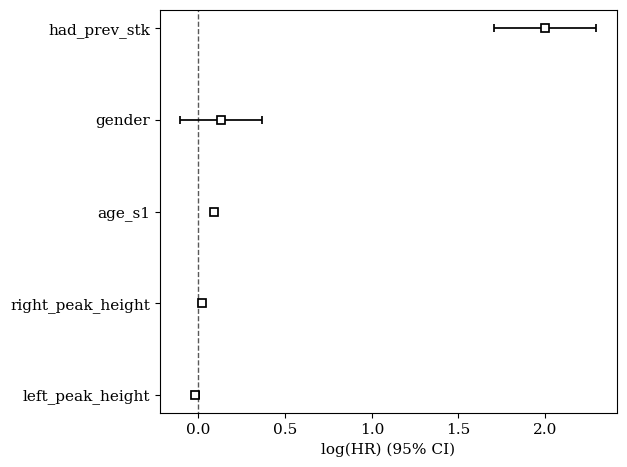

In [37]:
import matplotlib.pyplot as plt

best_model.plot()
plt.tight_layout()
plt.savefig("best-model.png")

### Sensitivity Analysis

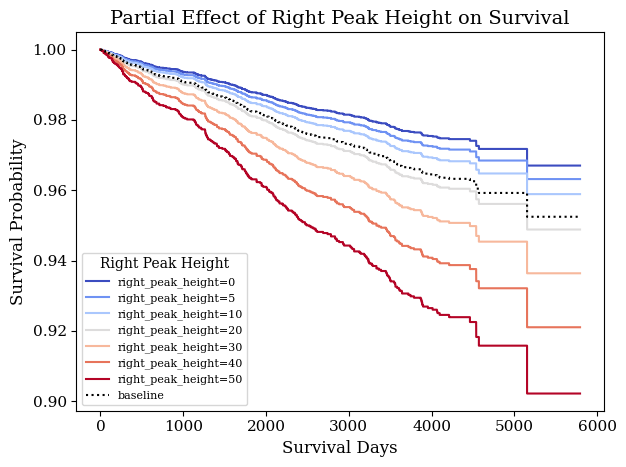

In [47]:
# Define the column mapping
column_mapping = {
    'age_s1': 'Age at Baseline',
    'had_prev_stk': 'Previous Stroke',
    'gender': 'Gender',
    'left_peak_height': 'Left Peak Height',
    'right_peak_height': 'Right Peak Height',
    'Status': 'Patient Had Stroke',
    'Survival_in_days': 'Survival Days'
}

# Create the plot
ax = best_model.plot_partial_effects_on_outcome(
    covariates='right_peak_height', 
    values=[0, 5, 10, 20, 30, 40, 50], 
    cmap='coolwarm'
)

# Set the title
plt.title(f"Partial Effect of {column_mapping['right_peak_height']} on Survival", fontsize=14)

# Customize x-axis
plt.xlabel(column_mapping['Survival_in_days'], fontsize=12)

# Customize y-axis
plt.ylabel("Survival Probability", fontsize=12)

# Adjust legend
plt.legend(title=column_mapping['right_peak_height'], title_fontsize=10, fontsize=8)

# Adjust layout and show
plt.tight_layout()
plt.savefig("sa-right-peak-height.png")
plt.show()

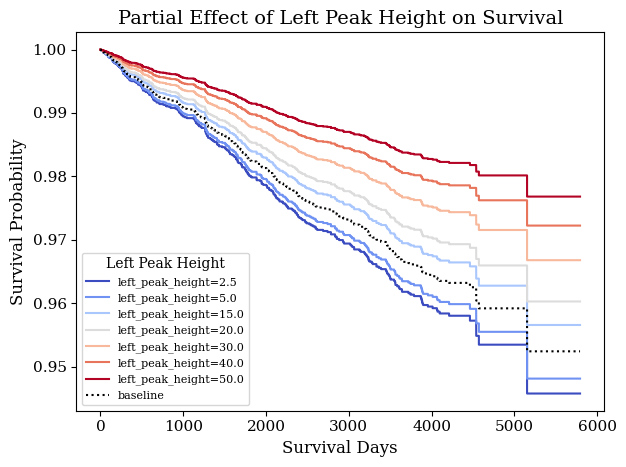

In [49]:
# Define the column mapping
column_mapping = {
    'age_s1': 'Age at Baseline',
    'had_prev_stk': 'Previous Stroke',
    'gender': 'Gender',
    'left_peak_height': 'Left Peak Height',
    'right_peak_height': 'Right Peak Height',
    'Status': 'Patient Had Stroke',
    'Survival_in_days': 'Survival Days'
}

# Create the plot
ax = best_model.plot_partial_effects_on_outcome(
    covariates='left_peak_height', 
    values=[2.5, 5, 15, 20, 30, 40, 50], 
    cmap='coolwarm'
)

# Set the title
plt.title(f"Partial Effect of {column_mapping['left_peak_height']} on Survival", fontsize=14)

# Customize x-axis
plt.xlabel(column_mapping['Survival_in_days'], fontsize=12)

# Customize y-axis
plt.ylabel("Survival Probability", fontsize=12)

# Adjust legend
plt.legend(title=column_mapping['left_peak_height'], title_fontsize=10, fontsize=8)

# Adjust layout and show
plt.tight_layout()
plt.savefig("sa-left-peak-height.png")
plt.show()

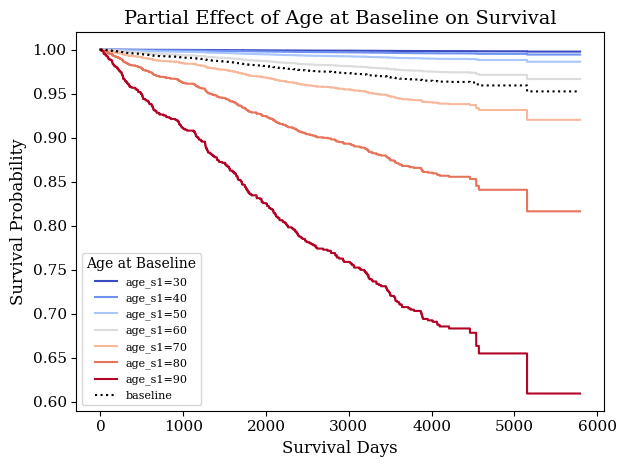

In [50]:
# Define the column mapping
column_mapping = {
    'age_s1': 'Age at Baseline',
    'had_prev_stk': 'Previous Stroke',
    'gender': 'Gender',
    'left_peak_height': 'Left Peak Height',
    'right_peak_height': 'Right Peak Height',
    'Status': 'Patient Had Stroke',
    'Survival_in_days': 'Survival Days'
}

# Create the plot
ax = best_model.plot_partial_effects_on_outcome(
    covariates='age_s1', 
    values=[30, 40, 50, 60, 70, 80, 90], 
    cmap='coolwarm'
)

# Set the title
plt.title(f"Partial Effect of {column_mapping['age_s1']} on Survival", fontsize=14)

# Customize x-axis
plt.xlabel(column_mapping['Survival_in_days'], fontsize=12)

# Customize y-axis
plt.ylabel("Survival Probability", fontsize=12)

# Adjust legend
plt.legend(title=column_mapping['age_s1'], title_fontsize=10, fontsize=8)

# Adjust layout and show
plt.tight_layout()
plt.savefig("sa-age.png")
plt.show()

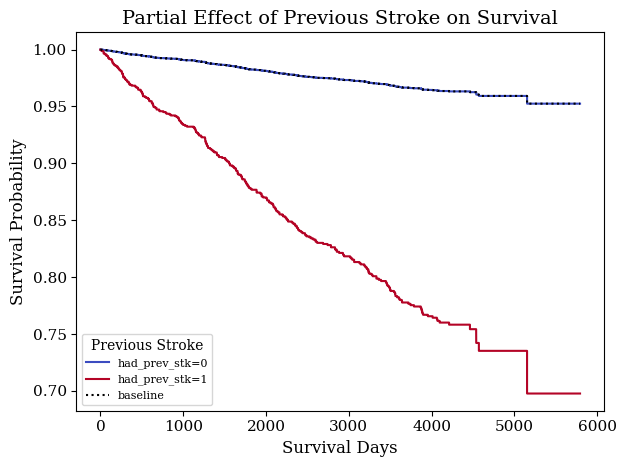

In [51]:
# Define the column mapping
column_mapping = {
    'age_s1': 'Age at Baseline',
    'had_prev_stk': 'Previous Stroke',
    'gender': 'Gender',
    'left_peak_height': 'Left Peak Height',
    'right_peak_height': 'Right Peak Height',
    'Status': 'Patient Had Stroke',
    'Survival_in_days': 'Survival Days'
}

# Create the plot
ax = best_model.plot_partial_effects_on_outcome(
    covariates='had_prev_stk', 
    values=[0, 1], 
    cmap='coolwarm'
)

# Set the title
plt.title(f"Partial Effect of {column_mapping['had_prev_stk']} on Survival", fontsize=14)

# Customize x-axis
plt.xlabel(column_mapping['Survival_in_days'], fontsize=12)

# Customize y-axis
plt.ylabel("Survival Probability", fontsize=12)

# Adjust legend
plt.legend(title=column_mapping['had_prev_stk'], title_fontsize=10, fontsize=8)

# Adjust layout and show
plt.tight_layout()
plt.savefig("sa-prev-strk.png")
plt.show()

### Checking assumptions

Checking assumptions like this is only necessary if your goal is inference or correlation. That is, you wish to understand the influence of a covariate on the survival duration & outcome. If your goal is prediction, checking model assumptions is less important since your goal is to maximize an accuracy metric, and not learn about how the model is making that prediction.
Source: https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html

In [52]:
best_model.check_assumptions(data_x_surv)

Proportional hazard assumption looks okay.


[]

### Predicted vs. actual survival

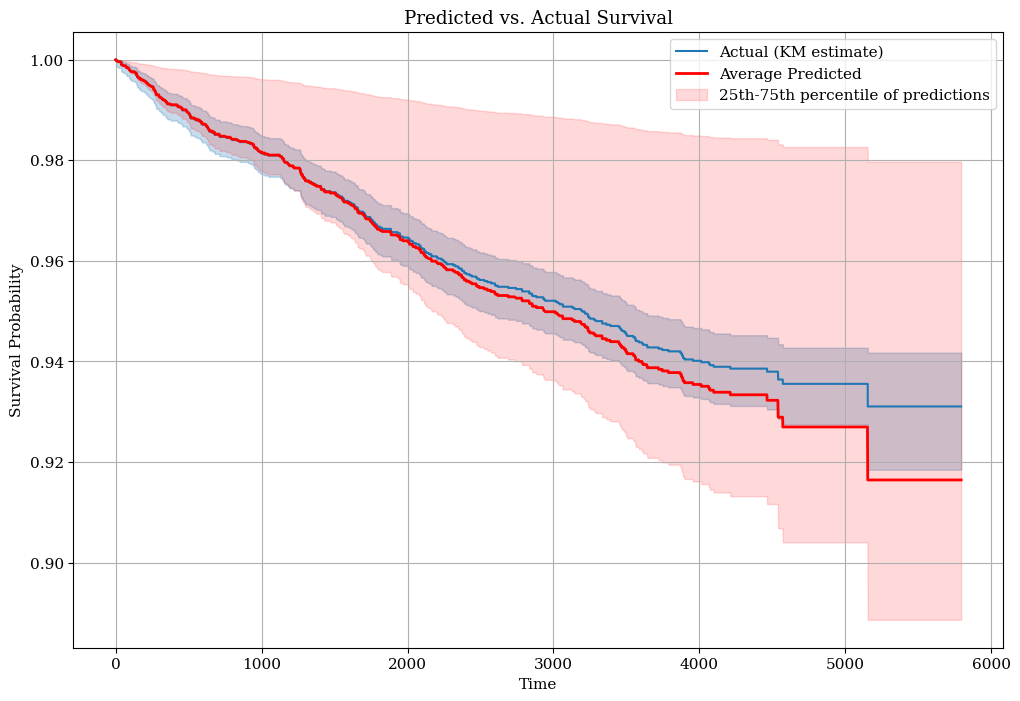

In [53]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_improved_survival_comparison(model, data, duration_col, event_col):
    # Fit Kaplan-Meier estimator for actual survival
    kmf = KaplanMeierFitter()
    kmf.fit(data[duration_col], data[event_col], label="Actual (KM estimate)")

    # Get predicted survival from the model
    predicted_survival = model.predict_survival_function(data)

    # Calculate average predicted survival
    average_predicted = predicted_survival.mean(axis=1)

    # Plot
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Plot Kaplan-Meier estimate with confidence intervals
    kmf.plot(ax=ax, ci_show=True)

    # Plot average predicted survivalx
    plt.plot(average_predicted.index, average_predicted.values, 
             label='Average Predicted', color='red', linewidth=2)

    # Calculate and plot 25th and 75th percentiles of predictions
    lower_percentile = predicted_survival.quantile(0.25, axis=1)
    upper_percentile = predicted_survival.quantile(0.75, axis=1)
    
    plt.fill_between(average_predicted.index, 
                     lower_percentile, upper_percentile, 
                     color='red', alpha=0.15, 
                     label='25th-75th percentile of predictions')

    plt.title("Predicted vs. Actual Survival")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.grid(True)
    plt.savefig("predicted-vs-actual.png")
    plt.show()

# Usage
plot_improved_survival_comparison(best_model, data_x_surv, 'duration', 'event')

### Model marginals

In [61]:
r = best_model.compute_residuals(data_x_surv, 'martingale')
r.head()

,duration,event,martingale
29,0.1,False,0.0
622,0.1,False,0.0
688,0.1,False,0.0
716,0.1,False,0.0
784,0.1,False,0.0


<Axes: xlabel='duration', ylabel='martingale'>

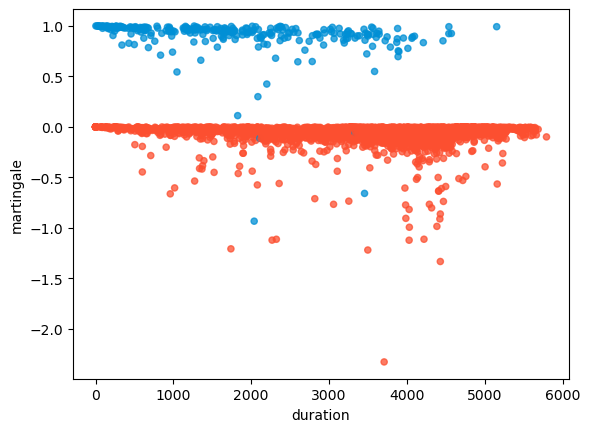

In [62]:
r.plot.scatter(
    x='duration', y='martingale', c=np.where(r['event'], '#008fd5', '#fc4f30'),
    alpha=0.75
)